In [55]:
from IPython.display import Image
import tensorflow as tf
from distutils.version import LooseVersion
from tensorflow.python.layers.core import Dense
import os

# Character Sequence to Sequence 
　　构建输入为一系列字母，输出为该序列的排序版本。

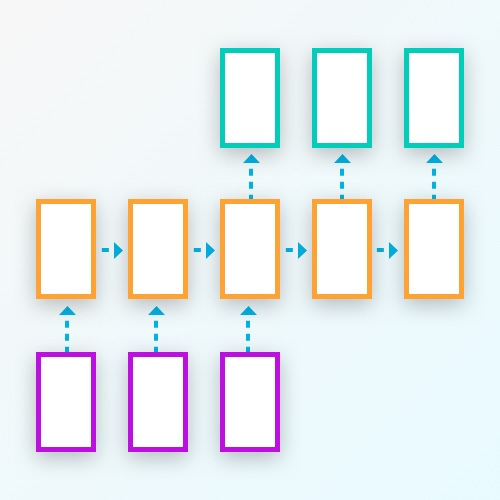

In [3]:
Image('https://github.com/udacity/deep-learning/raw/\
35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/sequence-to-sequence.jpg')

## 数据集 
　　数据集存放在  /data/ 文件夹下，有两个文件:
 * **letters_source.txt**: 输入字母的序列列表，每个序列为一行，每一行为一个单词。
 * **letters_target.txt**: 目标值（y值）。每个序列对应 letters_source.txt 的输入序列。每一行是排序后的单词。比如 letters_source 的第一行为 'bsaqq'，letters_target为排序后的 'abqqs'。

In [4]:
import numpy as np
import time
import os

def load_data(path):
    input_file = os.path.join(path)
    with open(input_file, "r", encoding='utf-8', errors='ignore') as f:
        data = f.read()

    return data

source_path = 'data/letters_source.txt'
target_path = 'data/letters_target.txt'

source_sentences = load_data(source_path)
target_sentences = load_data(target_path)

In [5]:
# 输入序列，前几行的单词
source_sentences[:50].split('\n')

['bsaqq',
 'npy',
 'lbwuj',
 'bqv',
 'kial',
 'tddam',
 'edxpjpg',
 'nspv',
 'huloz',
 '']

In [7]:
# 输出序列的每行对应输入序列的每行，但输出序列为排序好的单词
target_sentences[:50].split('\n')

['abqqs',
 'npy',
 'bjluw',
 'bqv',
 'aikl',
 'addmt',
 'degjppx',
 'npsv',
 'hlouz',
 '']

## 预处理
　　需要将每个字符串转为字符列表，然后将字符列表转换为词汇表中对应的int值。即将每行（每个单词）的每个字母转为对应的数字ID，比如['abc'] -> [[1], [2], [3]] 这种。除了将文本转为数字外，还需要四种字符:
- <PAD>，补全字符，保持每个 batch 的序列长度一致；
- <EOS>, 解码器端的句子结束标识符；
- <UNK>, 没出现过的词或低频词，使用它来替代；
- <GO>, 解码器端的句子起始标识符。

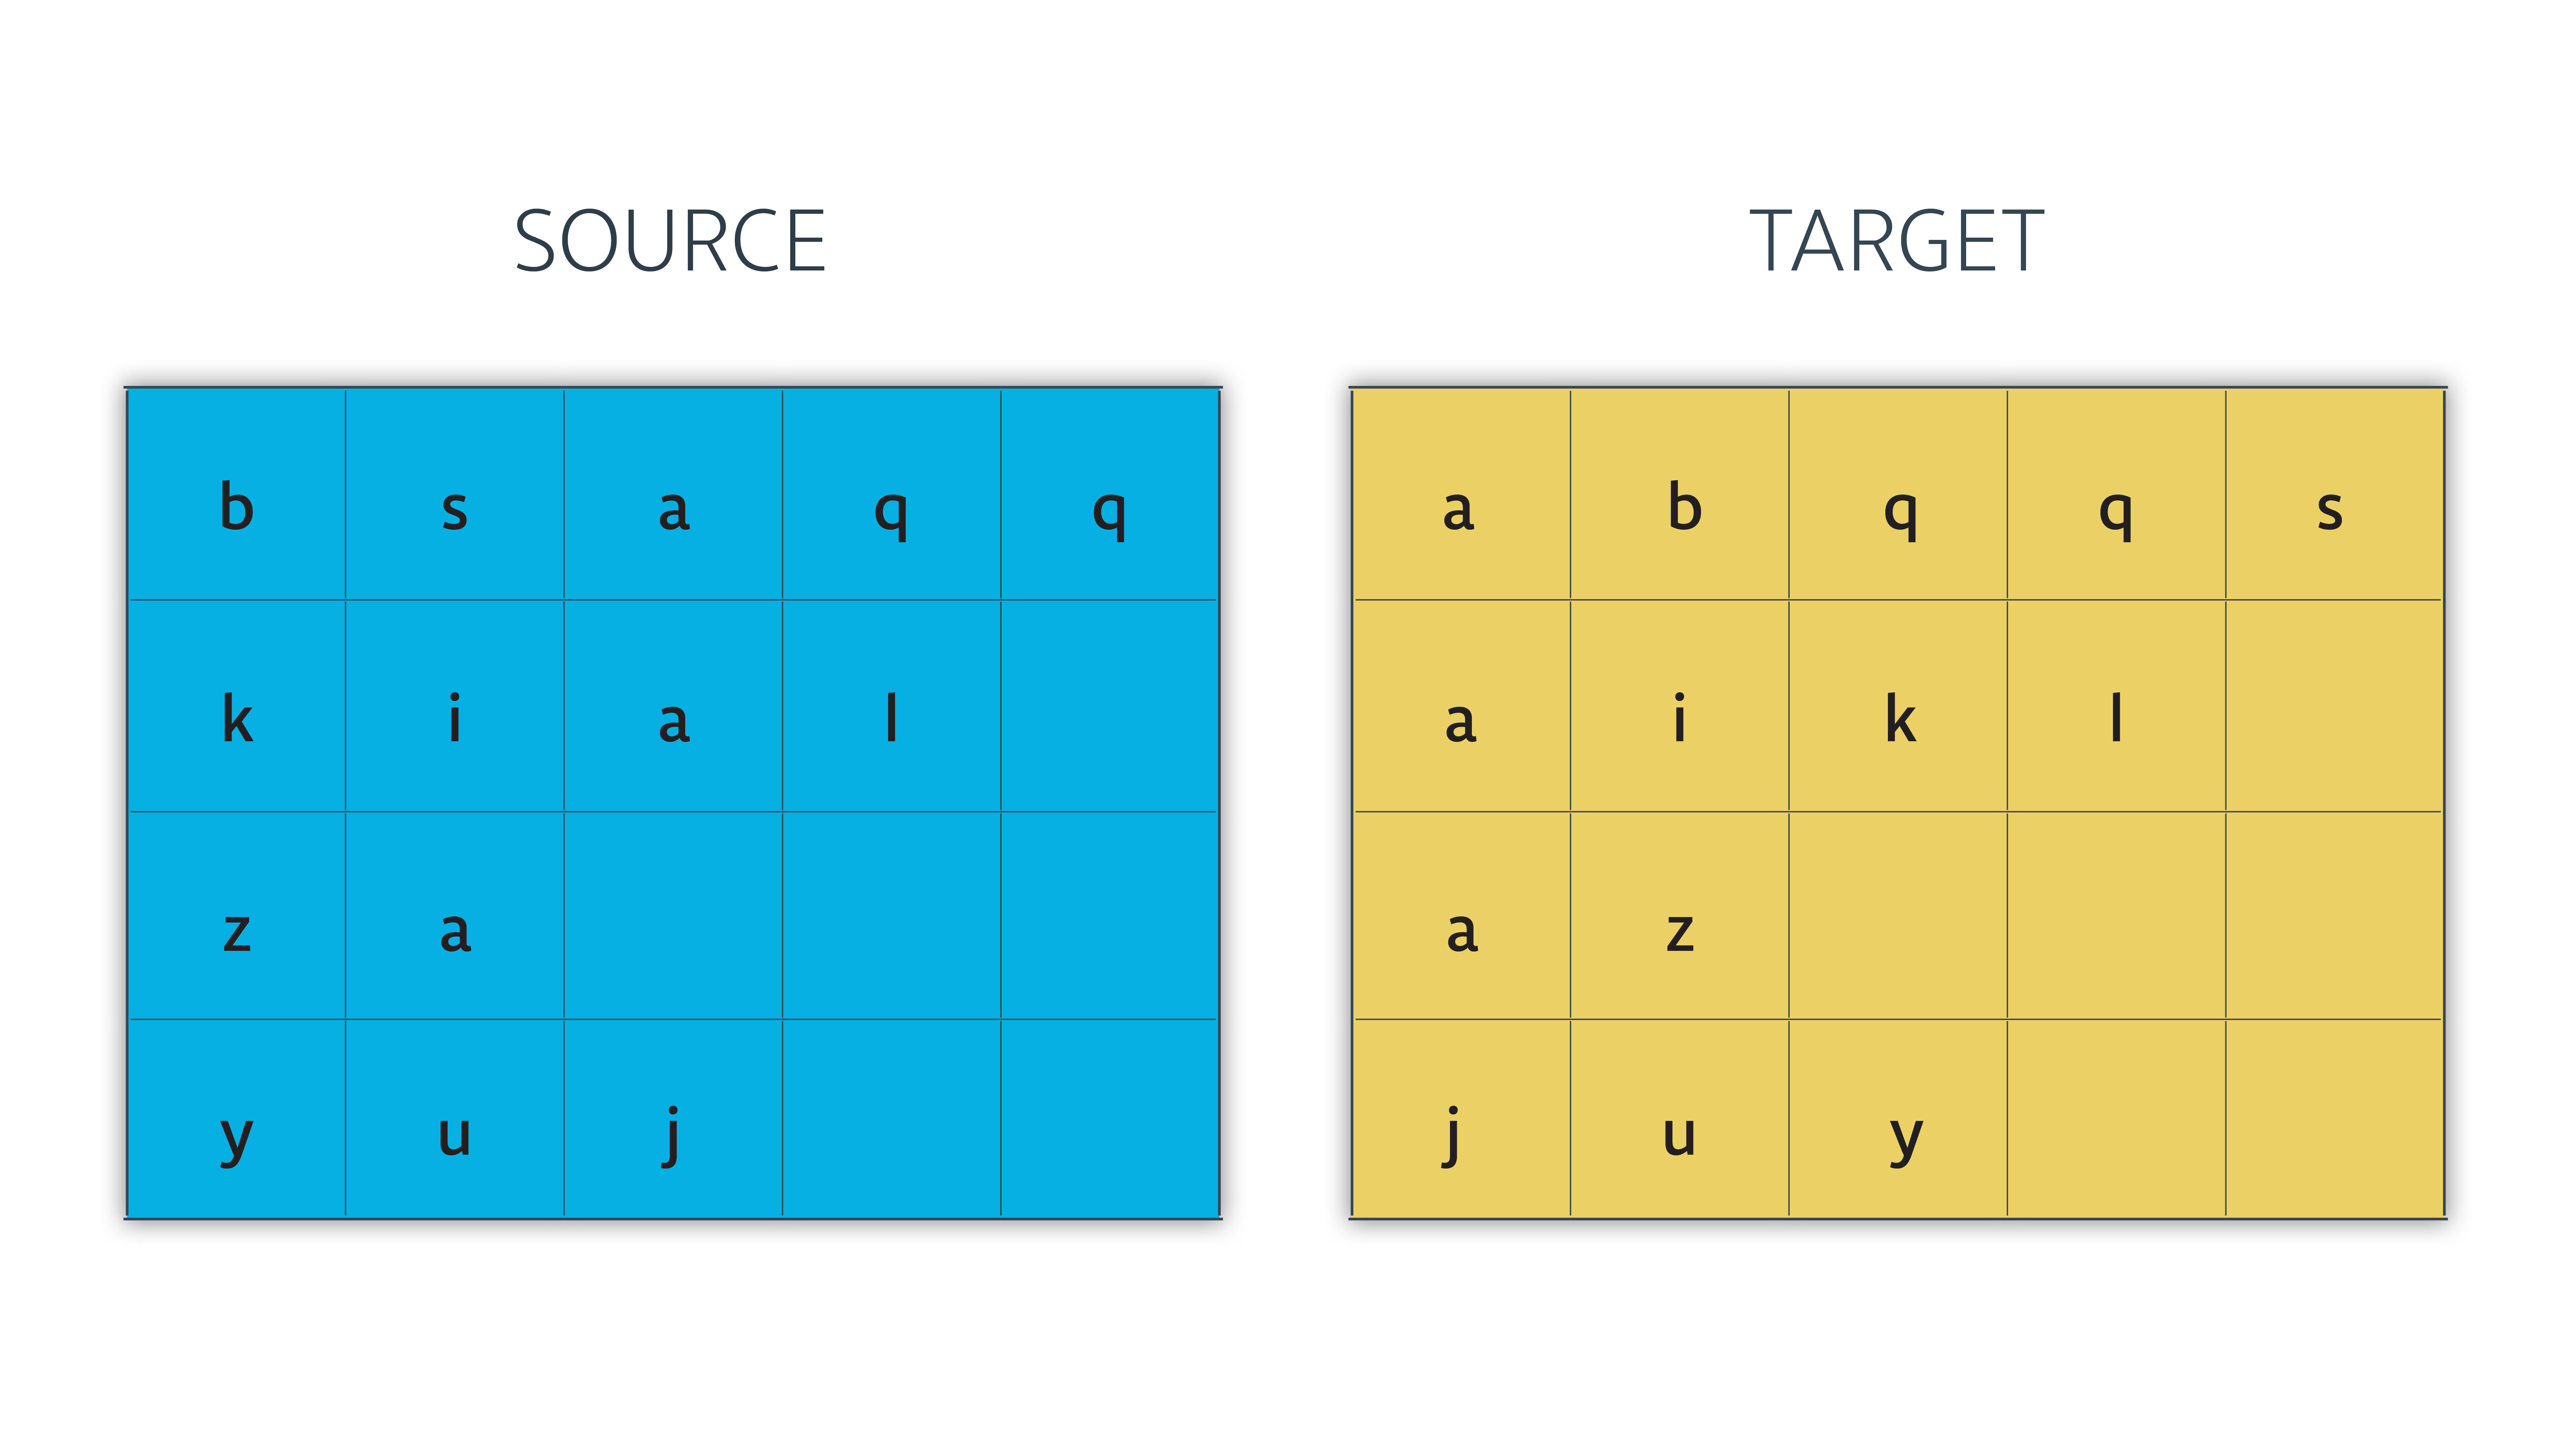

In [8]:
Image('https://github.com/udacity/deep-learning/raw/\
35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/source_and_target_arrays.png')

In [9]:
# 映射表，将输入文本转为数字
def extract_character_vocab(data):
    special_words = ['<PAD>', '<UNK>', '<GO>', '<EOS>']
    
    # 该 data 用到的字母，如{'a',  'b',  'c', 'd', ...}
    set_words = set([character for line in data.split('\n') for character in line])
    # 每个字母一个 id，如 {0: '<PAD>', 1: '<UNK>',  2: '<GO>',  3: '<EOS>',  4: 'c',  5: 'y', ...}
    int_to_vocab = {word_i: word for word_i, word in enumerate(special_words + list(set_words))}
    # 字典中的 key 和 value 对调
    vocab_to_int = {word: word_i for word_i, word in int_to_vocab.items()}
    
    return int_to_vocab, vocab_to_int

# 建立整数转为字母和字母转为整数的字典
source_int_to_letter, source_letter_to_int = extract_character_vocab(source_sentences)
target_int_to_letter, target_letter_to_int = extract_character_vocab(target_sentences)

# 将每行的每个字母转为id，比如 'bsaqq' -> [26, 16, 6, 9, 9]，如果在字典中找不到字母的对应 id，则使用 source_letter_to_int['<UNK>']
source_letter_ids = [[source_letter_to_int.get(letter, source_letter_to_int['<UNK>']) for letter in line] for line in source_sentences.split('\n')]
# 与前面相同，但在结尾需加上 '<EOS>' 对应的 id
target_letter_ids = [[target_letter_to_int.get(letter, target_letter_to_int['<UNK>']) for letter in line] +
                     [target_letter_to_int['<EOS>']] for line in target_sentences.split('\n')] 

print('Example source sequence')
print(source_letter_ids[:3])
print('\n')
print('Example target sequence')
print(target_letter_ids[:3])

Example source sequence
[[17, 16, 14, 27, 27], [19, 13, 25], [4, 17, 20, 12, 22]]


Example target sequence
[[14, 17, 27, 27, 16, 3], [19, 13, 25, 3], [17, 22, 4, 12, 20, 3]]


## 模型
### 超参数

In [10]:
# 迭代次数
epochs = 60
# batch 大小
batch_size = 128
# rnn 大小
rnn_size = 50
# 隐藏层层数
num_layers = 2
# 嵌入大小
encoding_embedding_size = 15
decoding_embedding_size = 15
# 学习速率
learning_rate = 0.001

### 输入

In [39]:
def get_model_inputs():
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    target_sequence_length = tf.placeholder(tf.int32, (None,), name='target_sequence_length')
    # 最大序列长度
    max_target_sequence_length = tf.reduce_max(target_sequence_length, name='max_target_len')
    source_sequence_length = tf.placeholder(tf.int32, (None,), name='source_sequence_length')
    
    return input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length

### seq2seq模型
　　模型由以下部分组成: 

    2.1 Encoder
        - Embedding
        - Encoder cell
    2.2 Decoder
        1- Process decoder inputs
        2- Set up the decoder
            - Embedding
            - Decoder cell
            - Dense output layer
            - Training decoder
            - Inference decoder
    2.3 Seq2seq model connecting the encoder and decoder
    2.4 Build the training graph hooking up the model with the 
        optimizer

### 2.1 编码器
　　首先构建模型的编码器，对输入数据进行 embedding，即将嵌入数据传入编码器。
- 使用 [`tf.contrib.layers.embed_sequence`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence) 对输入数据进行 embedding。

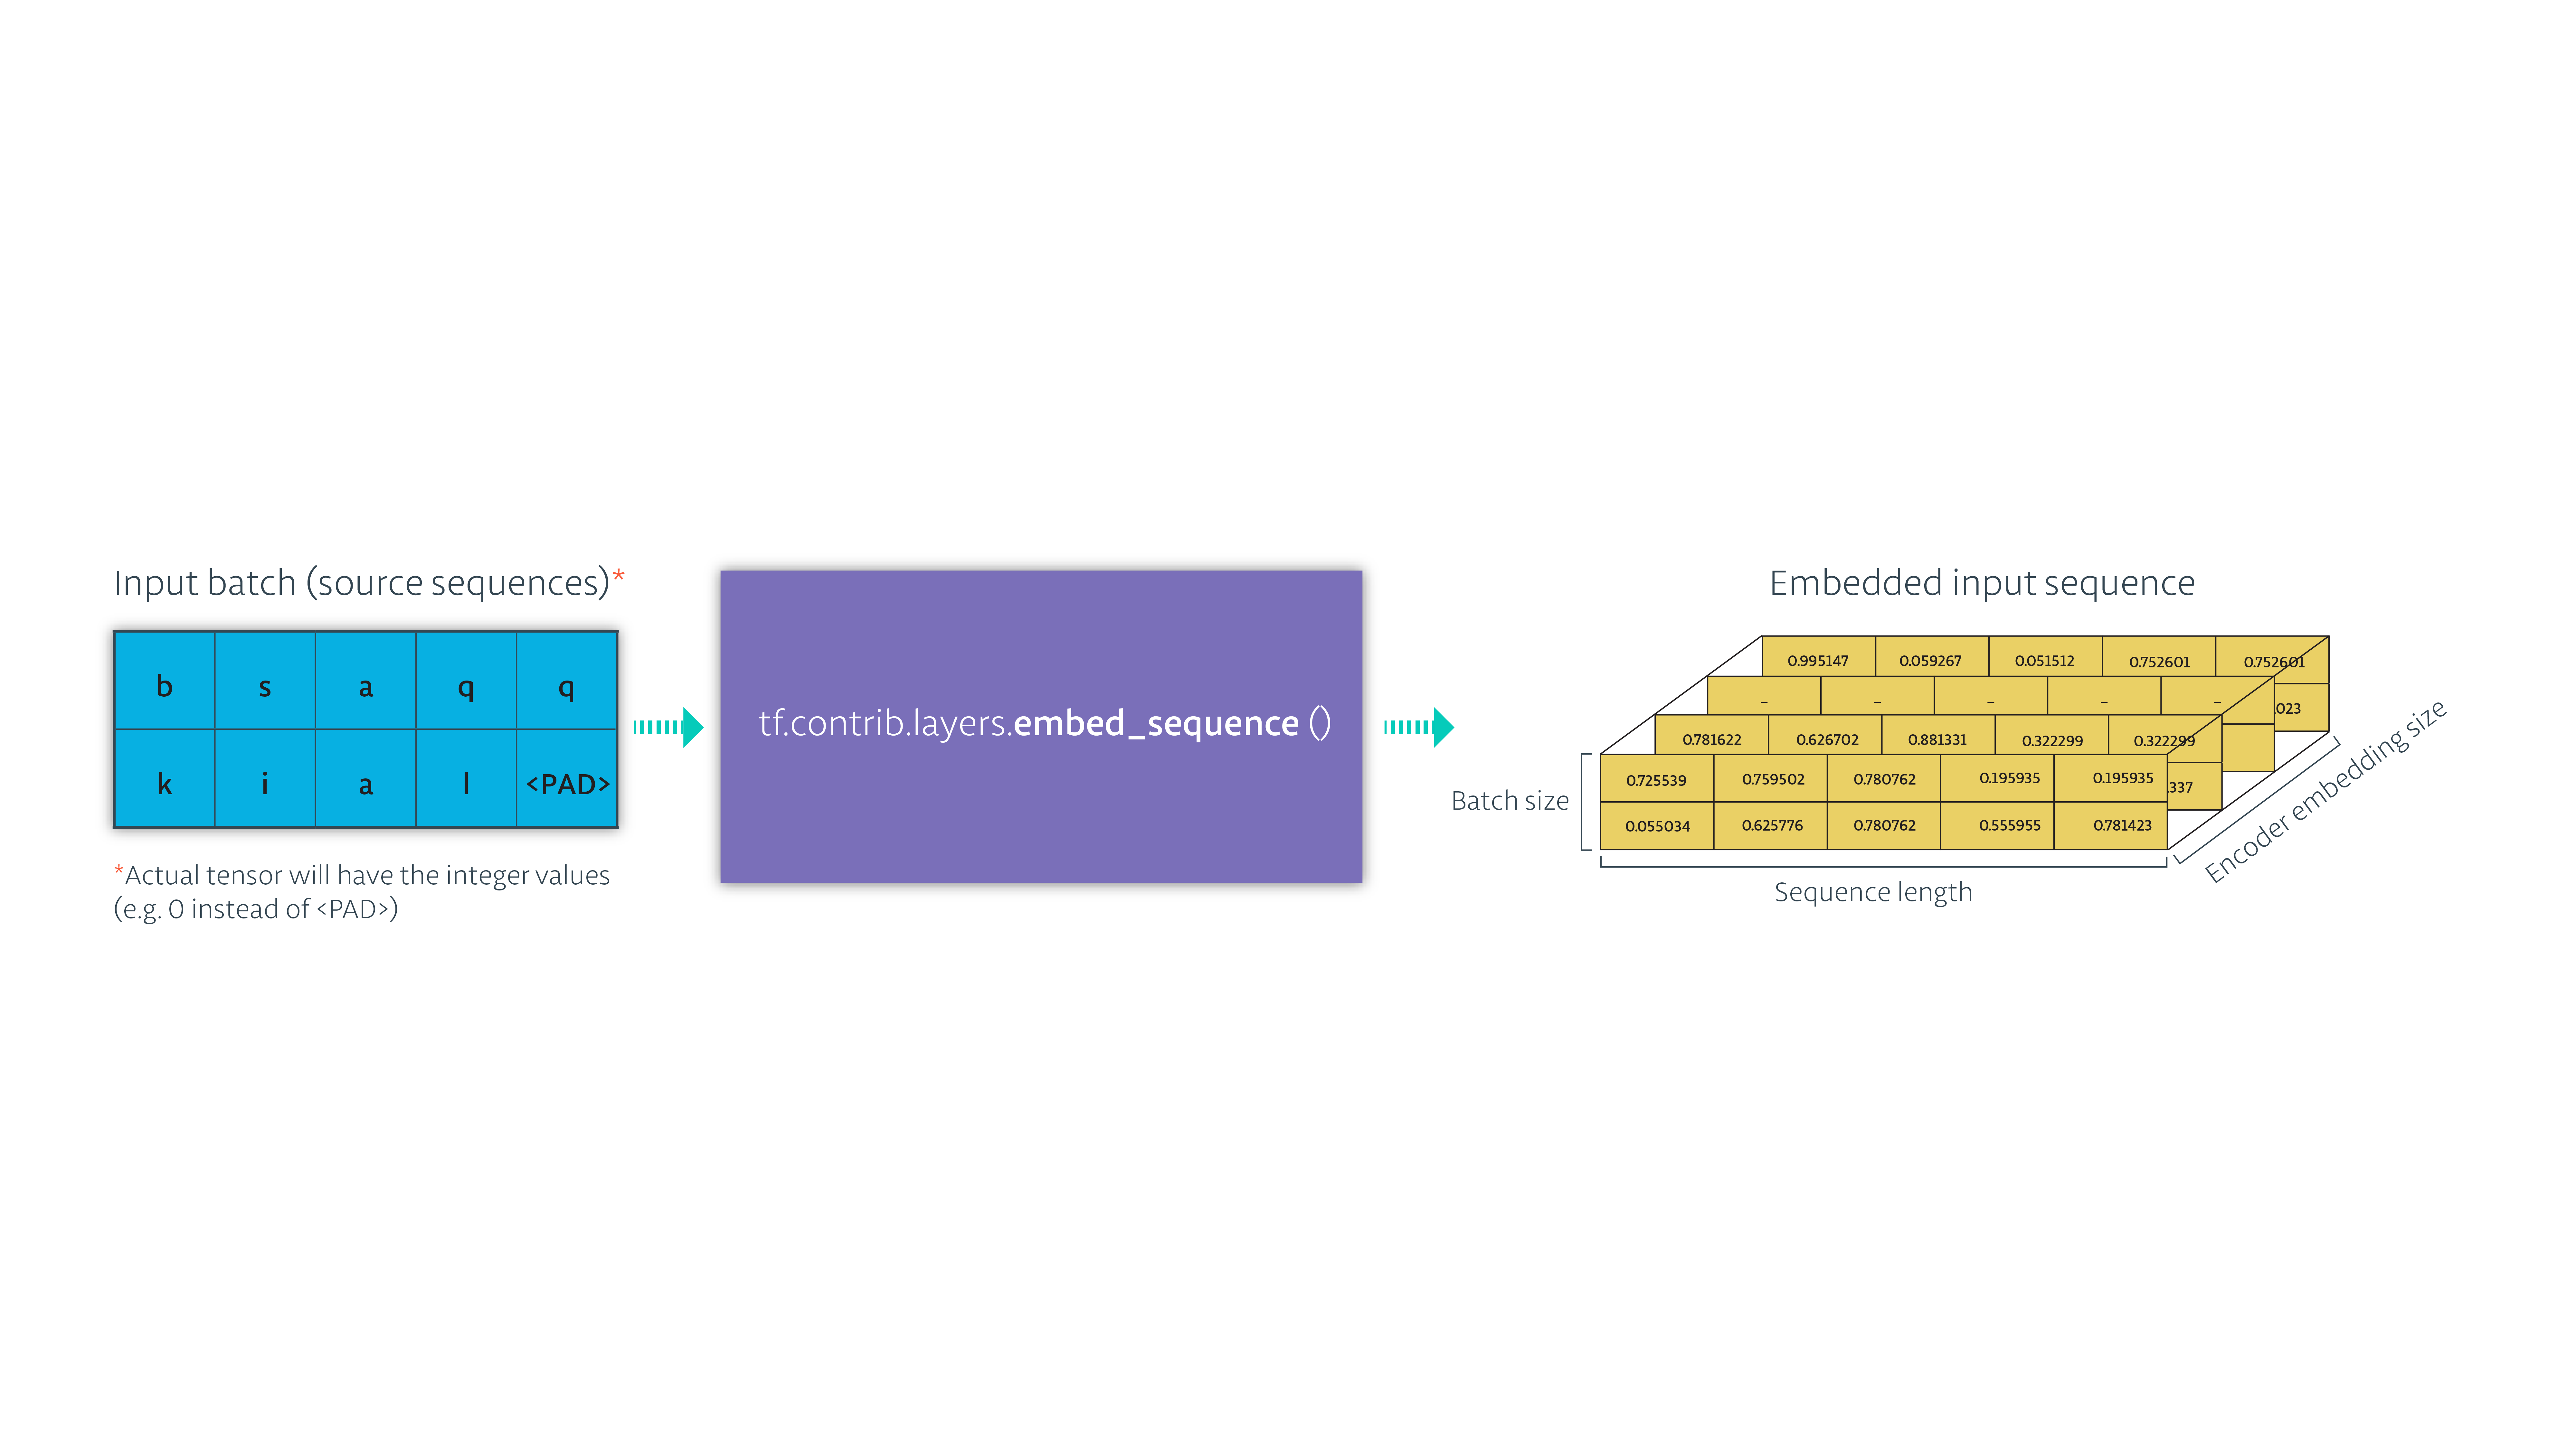

In [12]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/embed_sequence.png')

- 将 embedding 后的输入传入堆叠的RNN中，保持RNN的状态并忽略输出。

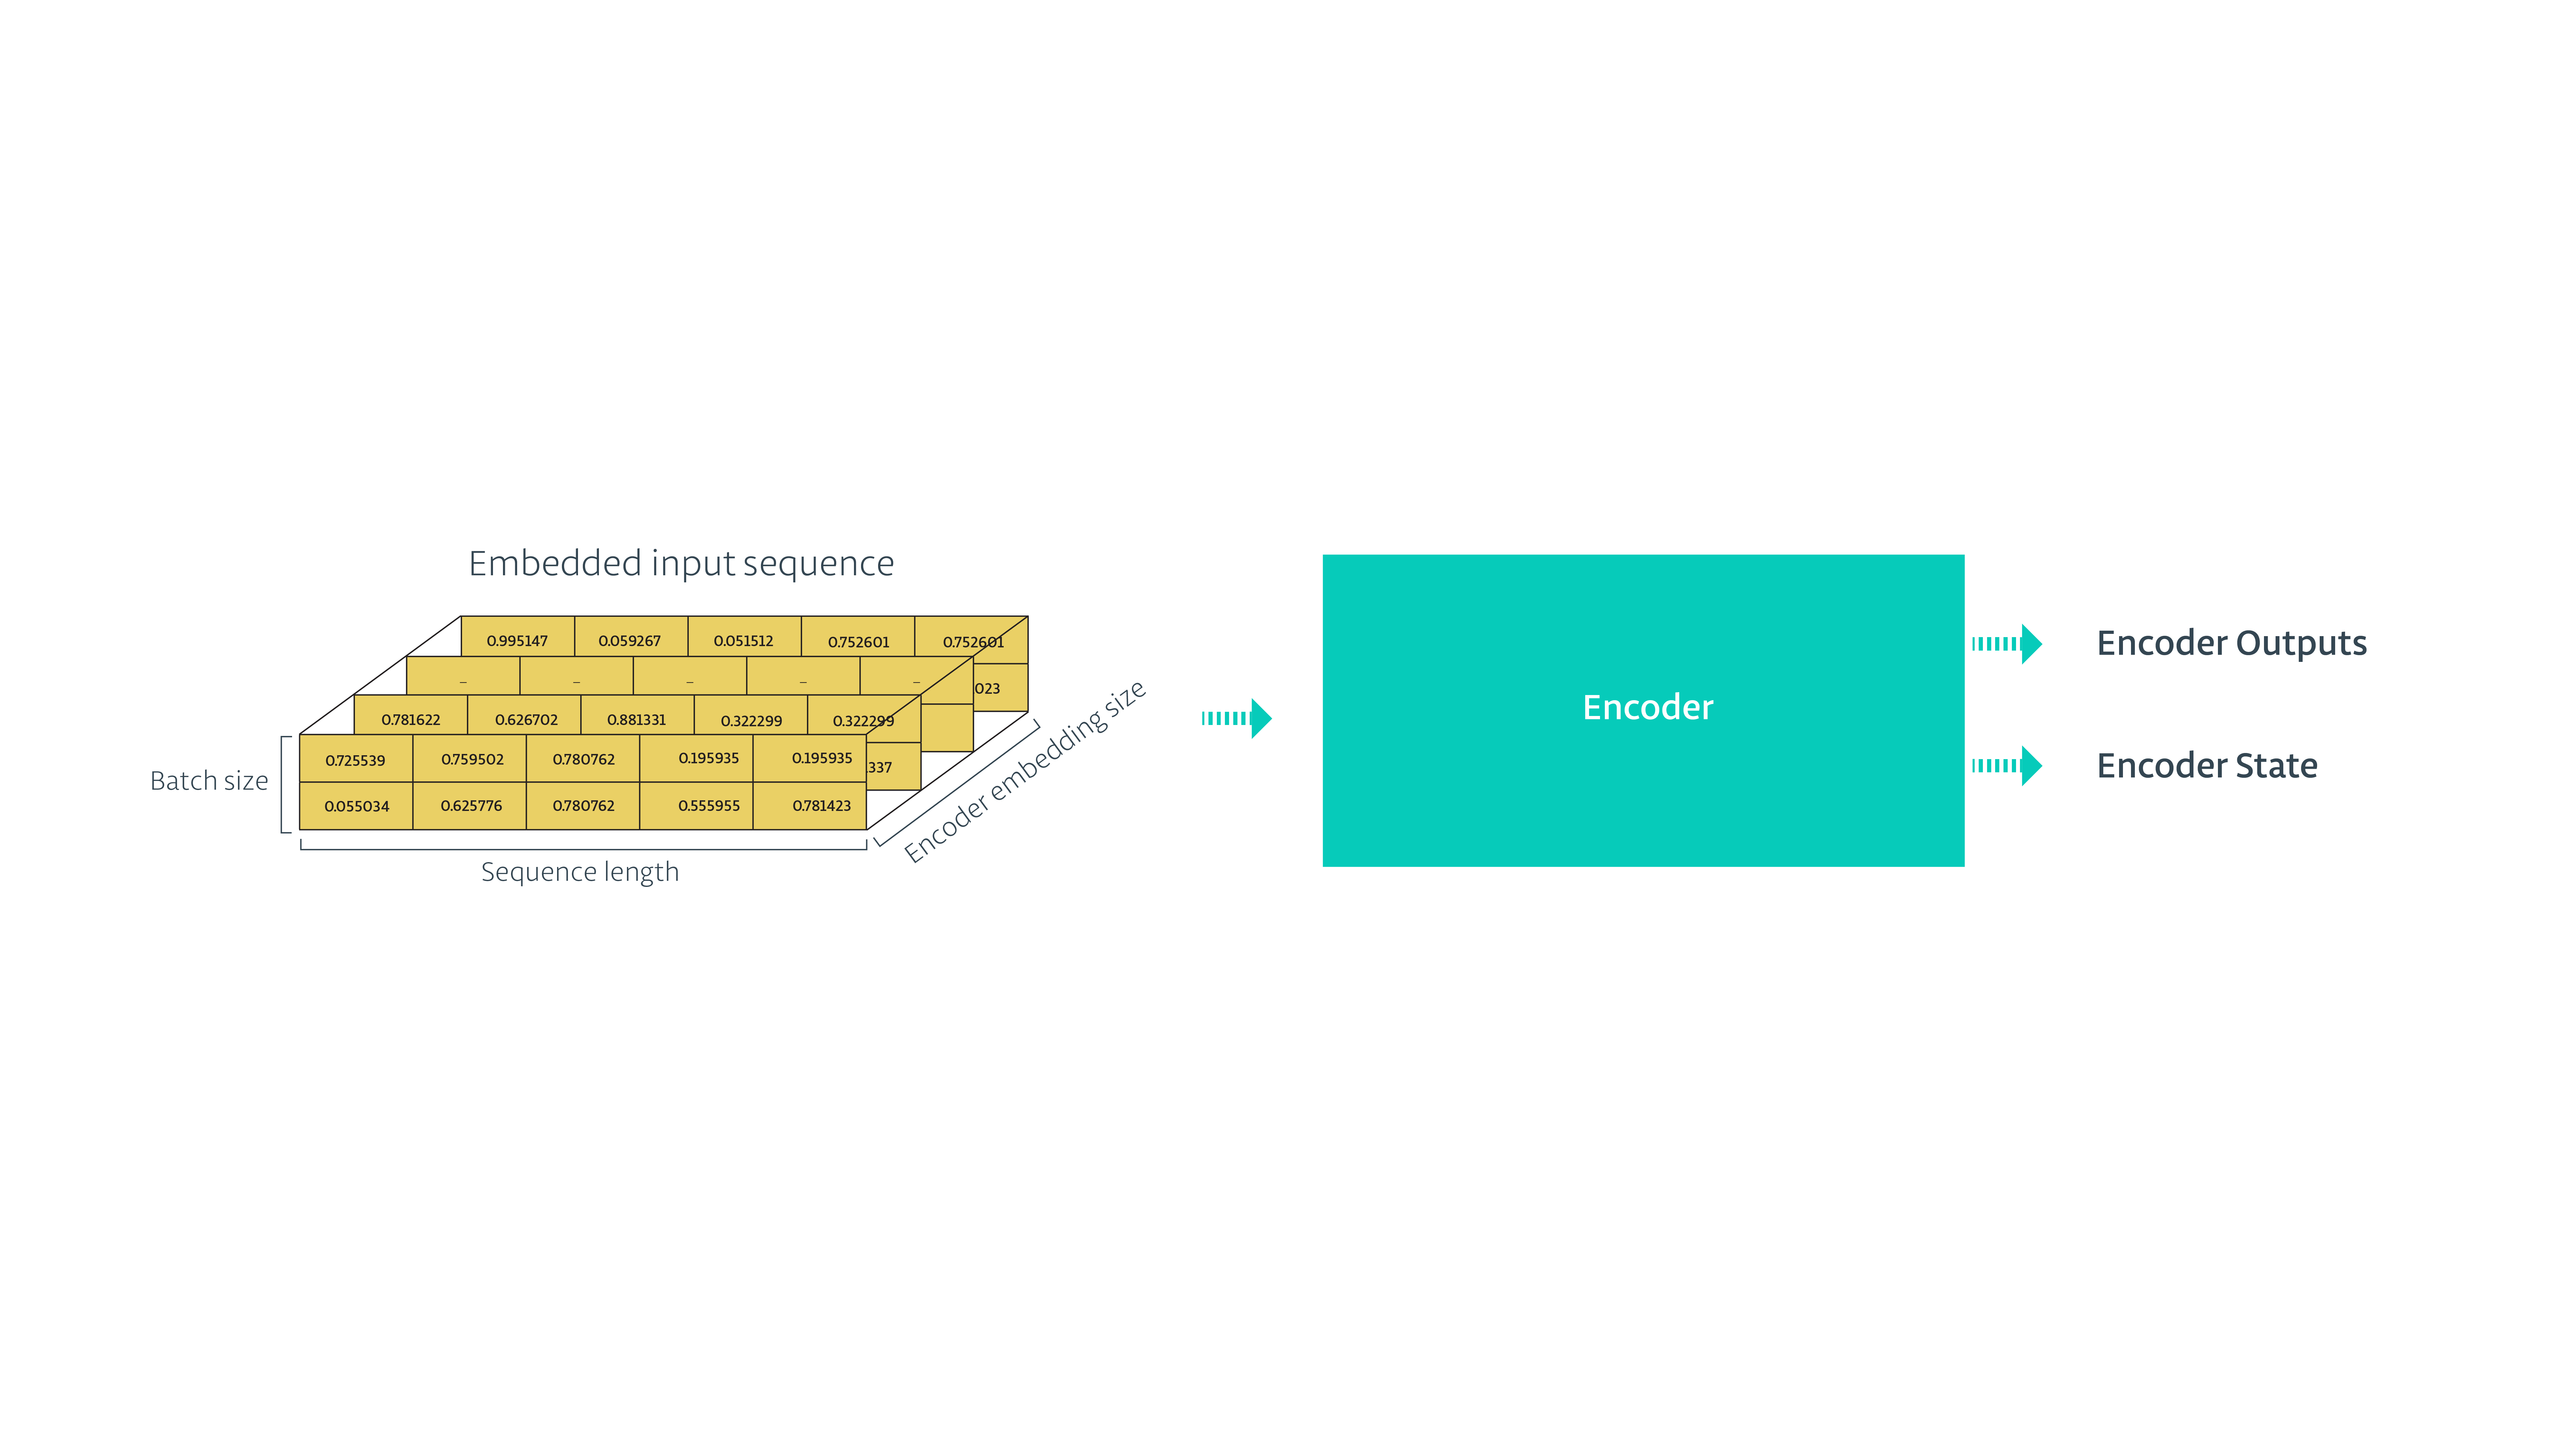

In [13]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/encoder.png')

In [40]:
# 构造编码层
def encoding_layer(input_data, rnn_size, num_layers,
                   source_sequence_length, source_vocab_size, 
                   encoding_embedding_size):
    '''
    Args:
        input_data: 输入数据
        rnn_size: rnn隐藏层的神经元数
        num_layers: 堆叠的 rnn cell 数量
        source_sequence_length: 源数据的序列长度
        source_vocab_size: 源数据的词典大小
        encoding_embedding_size: 嵌入大小（用于将输入矩阵转为嵌入矩阵）
    '''
    # 将输入数据转为嵌入数据
    enc_embed_input = tf.contrib.layers.embed_sequence(input_data, source_vocab_size, encoding_embedding_size)
    
    # 初始化 RNN cell
    def make_cell(rnn_size):
        enc_cell = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return enc_cell

    # 根据 num_layers 堆叠 rnn cell
    enc_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
    
    # 动态 rnn
    enc_output, enc_state = tf.nn.dynamic_rnn(enc_cell, enc_embed_input, sequence_length=source_sequence_length, dtype=tf.float32)
    
    return enc_output, enc_state

## 2.2 解码器
　　解码器是该模型涉及最多的部分，由以下组成:
  
    1- 处理解码器的输入，即对 target 数据进行处理
    2- decoder 由以下几个部分组成: 
        - Embedding
        - 解码层，decoder cell
        - 全连接输出层，输出每个时间序列的RNN的输出结果
        - Training decoder
        - Inference decoder


### 处理解码器的输入
　　在训练过程，目标序列（target数据）有两个作用:
 1. 使用目标序列来计算损失；
 2. 在训练过程中，将目标序列作为输入传给解码器端的RNN的每个阶段，不使用前一阶段的预测输出，使得模型鲁棒性更好。这也是为什么要构建 training 和predicting 两个解码器的原因。
 
　　现在我们先解决第二个点，假设目标序列的形式以字母形式出现像这样（这样做是为了可读性，在代码里，这些序列是 int 形式的）:

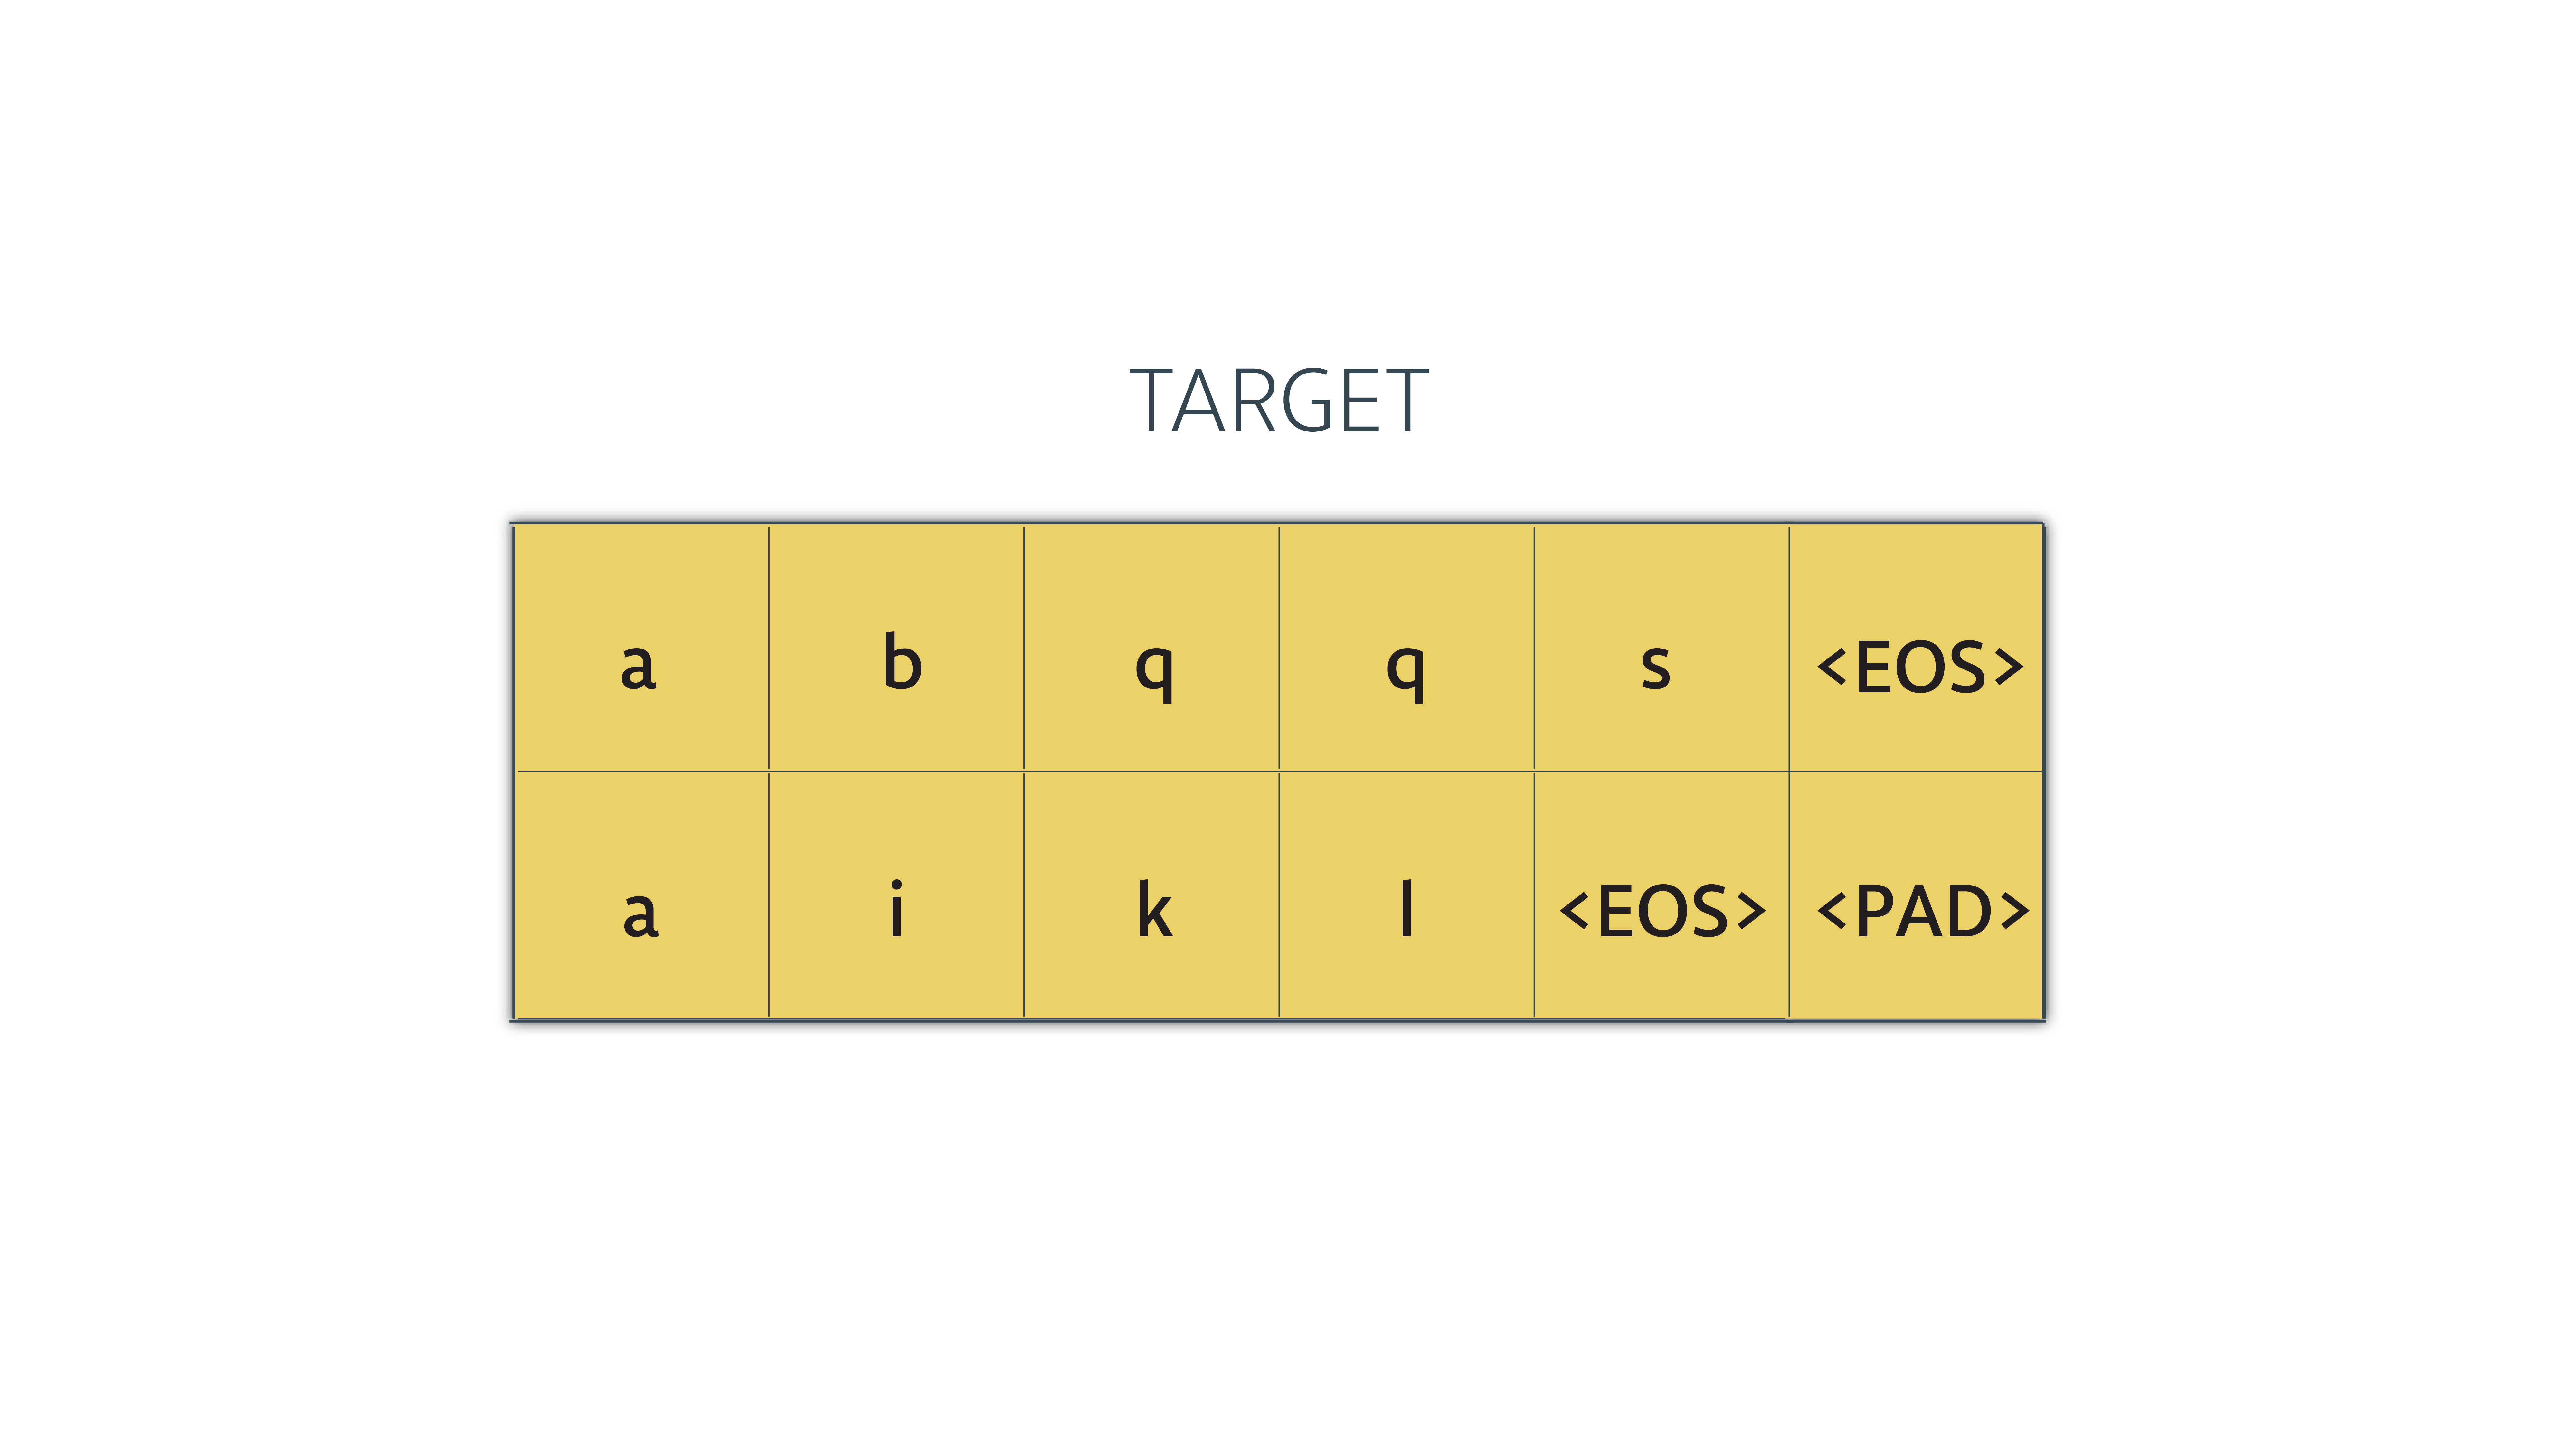

In [15]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/targets_1.png')

　　在将编码器的输出传入解码器前，需要对其张量做个简单的转换:
- 在每个时间步长中，将目标序列的输入传入解码器中。最后一个时间步长，即目标序列中的最后一个单词是没有用的。使用下图来解释，左边输入序列 [A, B, C] 为编码器，右边目标序列 [<go>, W, X, Y, Z, <eos>] 为解码器的输入，其中< go>，W，X，Y，Z 是每个时间步长上输入给解码器的内容，同时还需要在前面添加 <go> 标识，告诉模型折代表一个句子的开始。因此，解码器无法用于目标序列中的最后一项，所以移除最后一项。使用 tf.strided_slice() 方法，来处理张量。

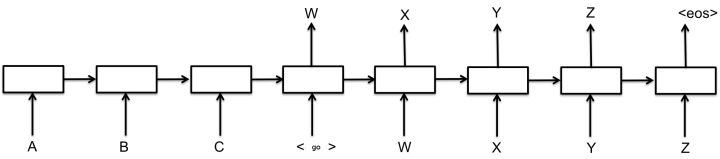

In [60]:
Image('https://raw.githubusercontent.com/martin-1992/deep-learning-note/master/seq2seq/v2-b2f4e56107dc06e4916a70d899e46203_hd.jpg')

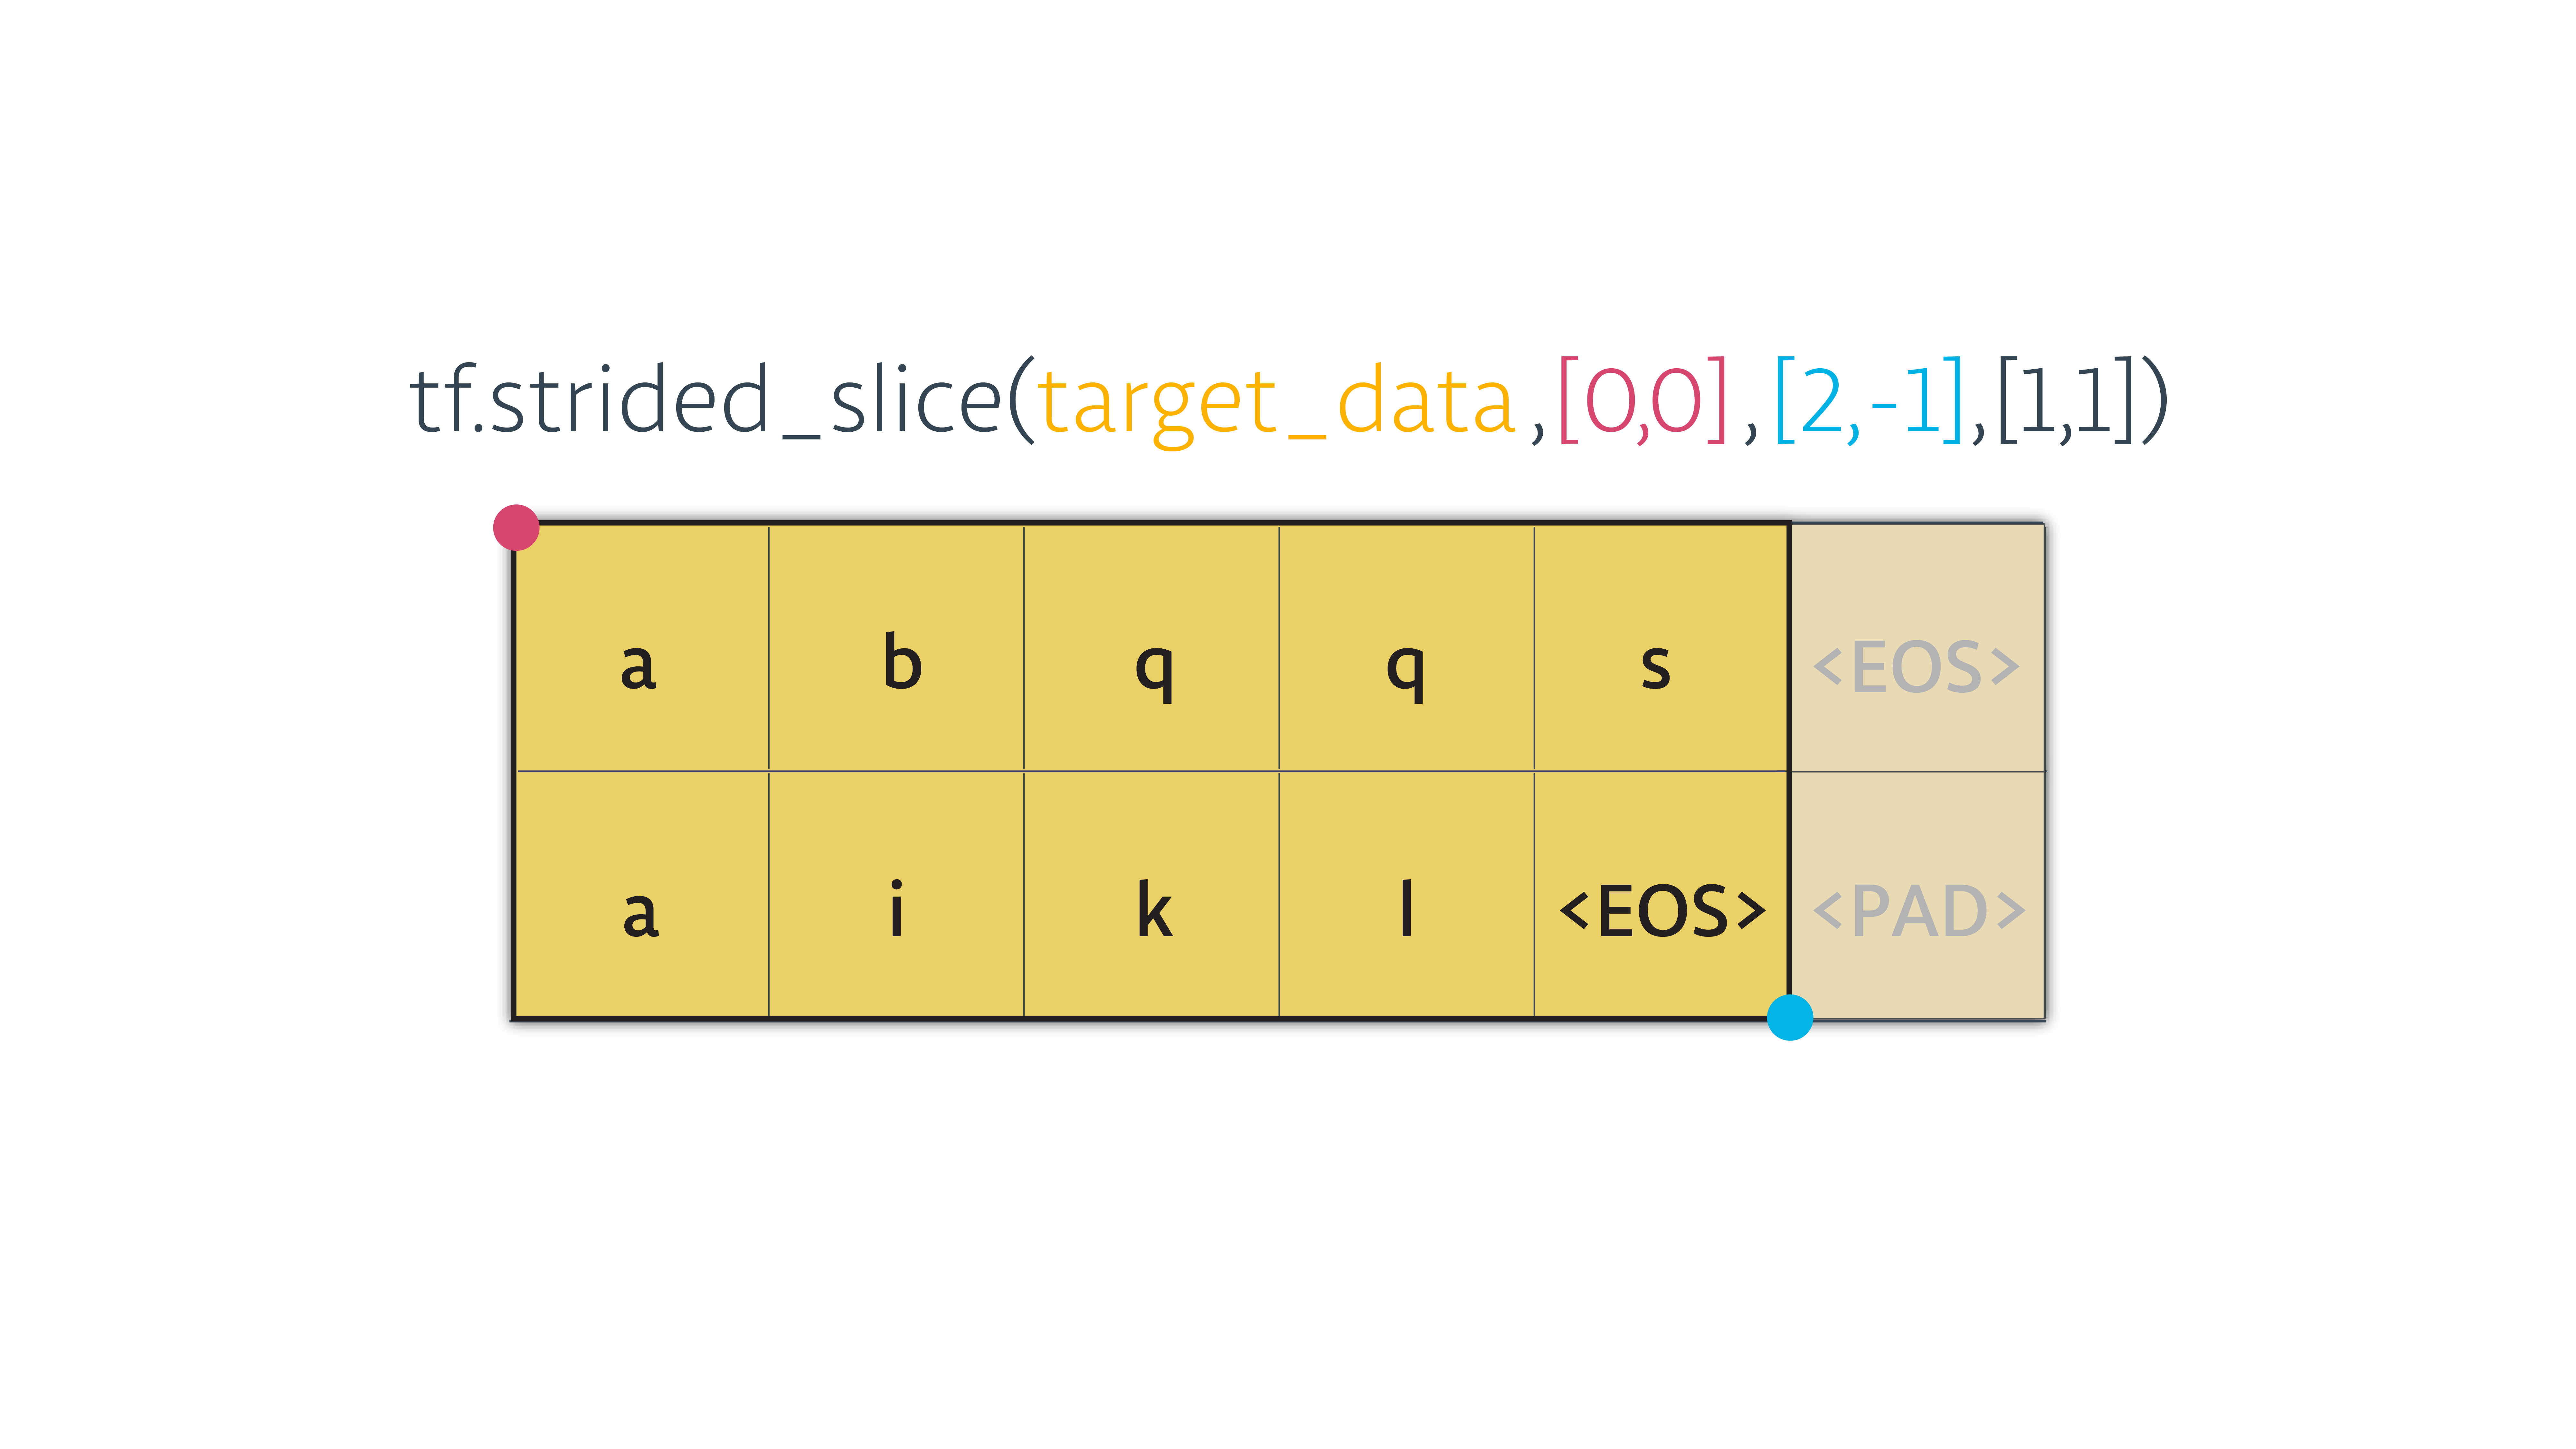

In [16]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/strided_slice_1.png')

- 传到解码器的每个目标序列的第一项必须为 GO 符号，所以将其添加开头

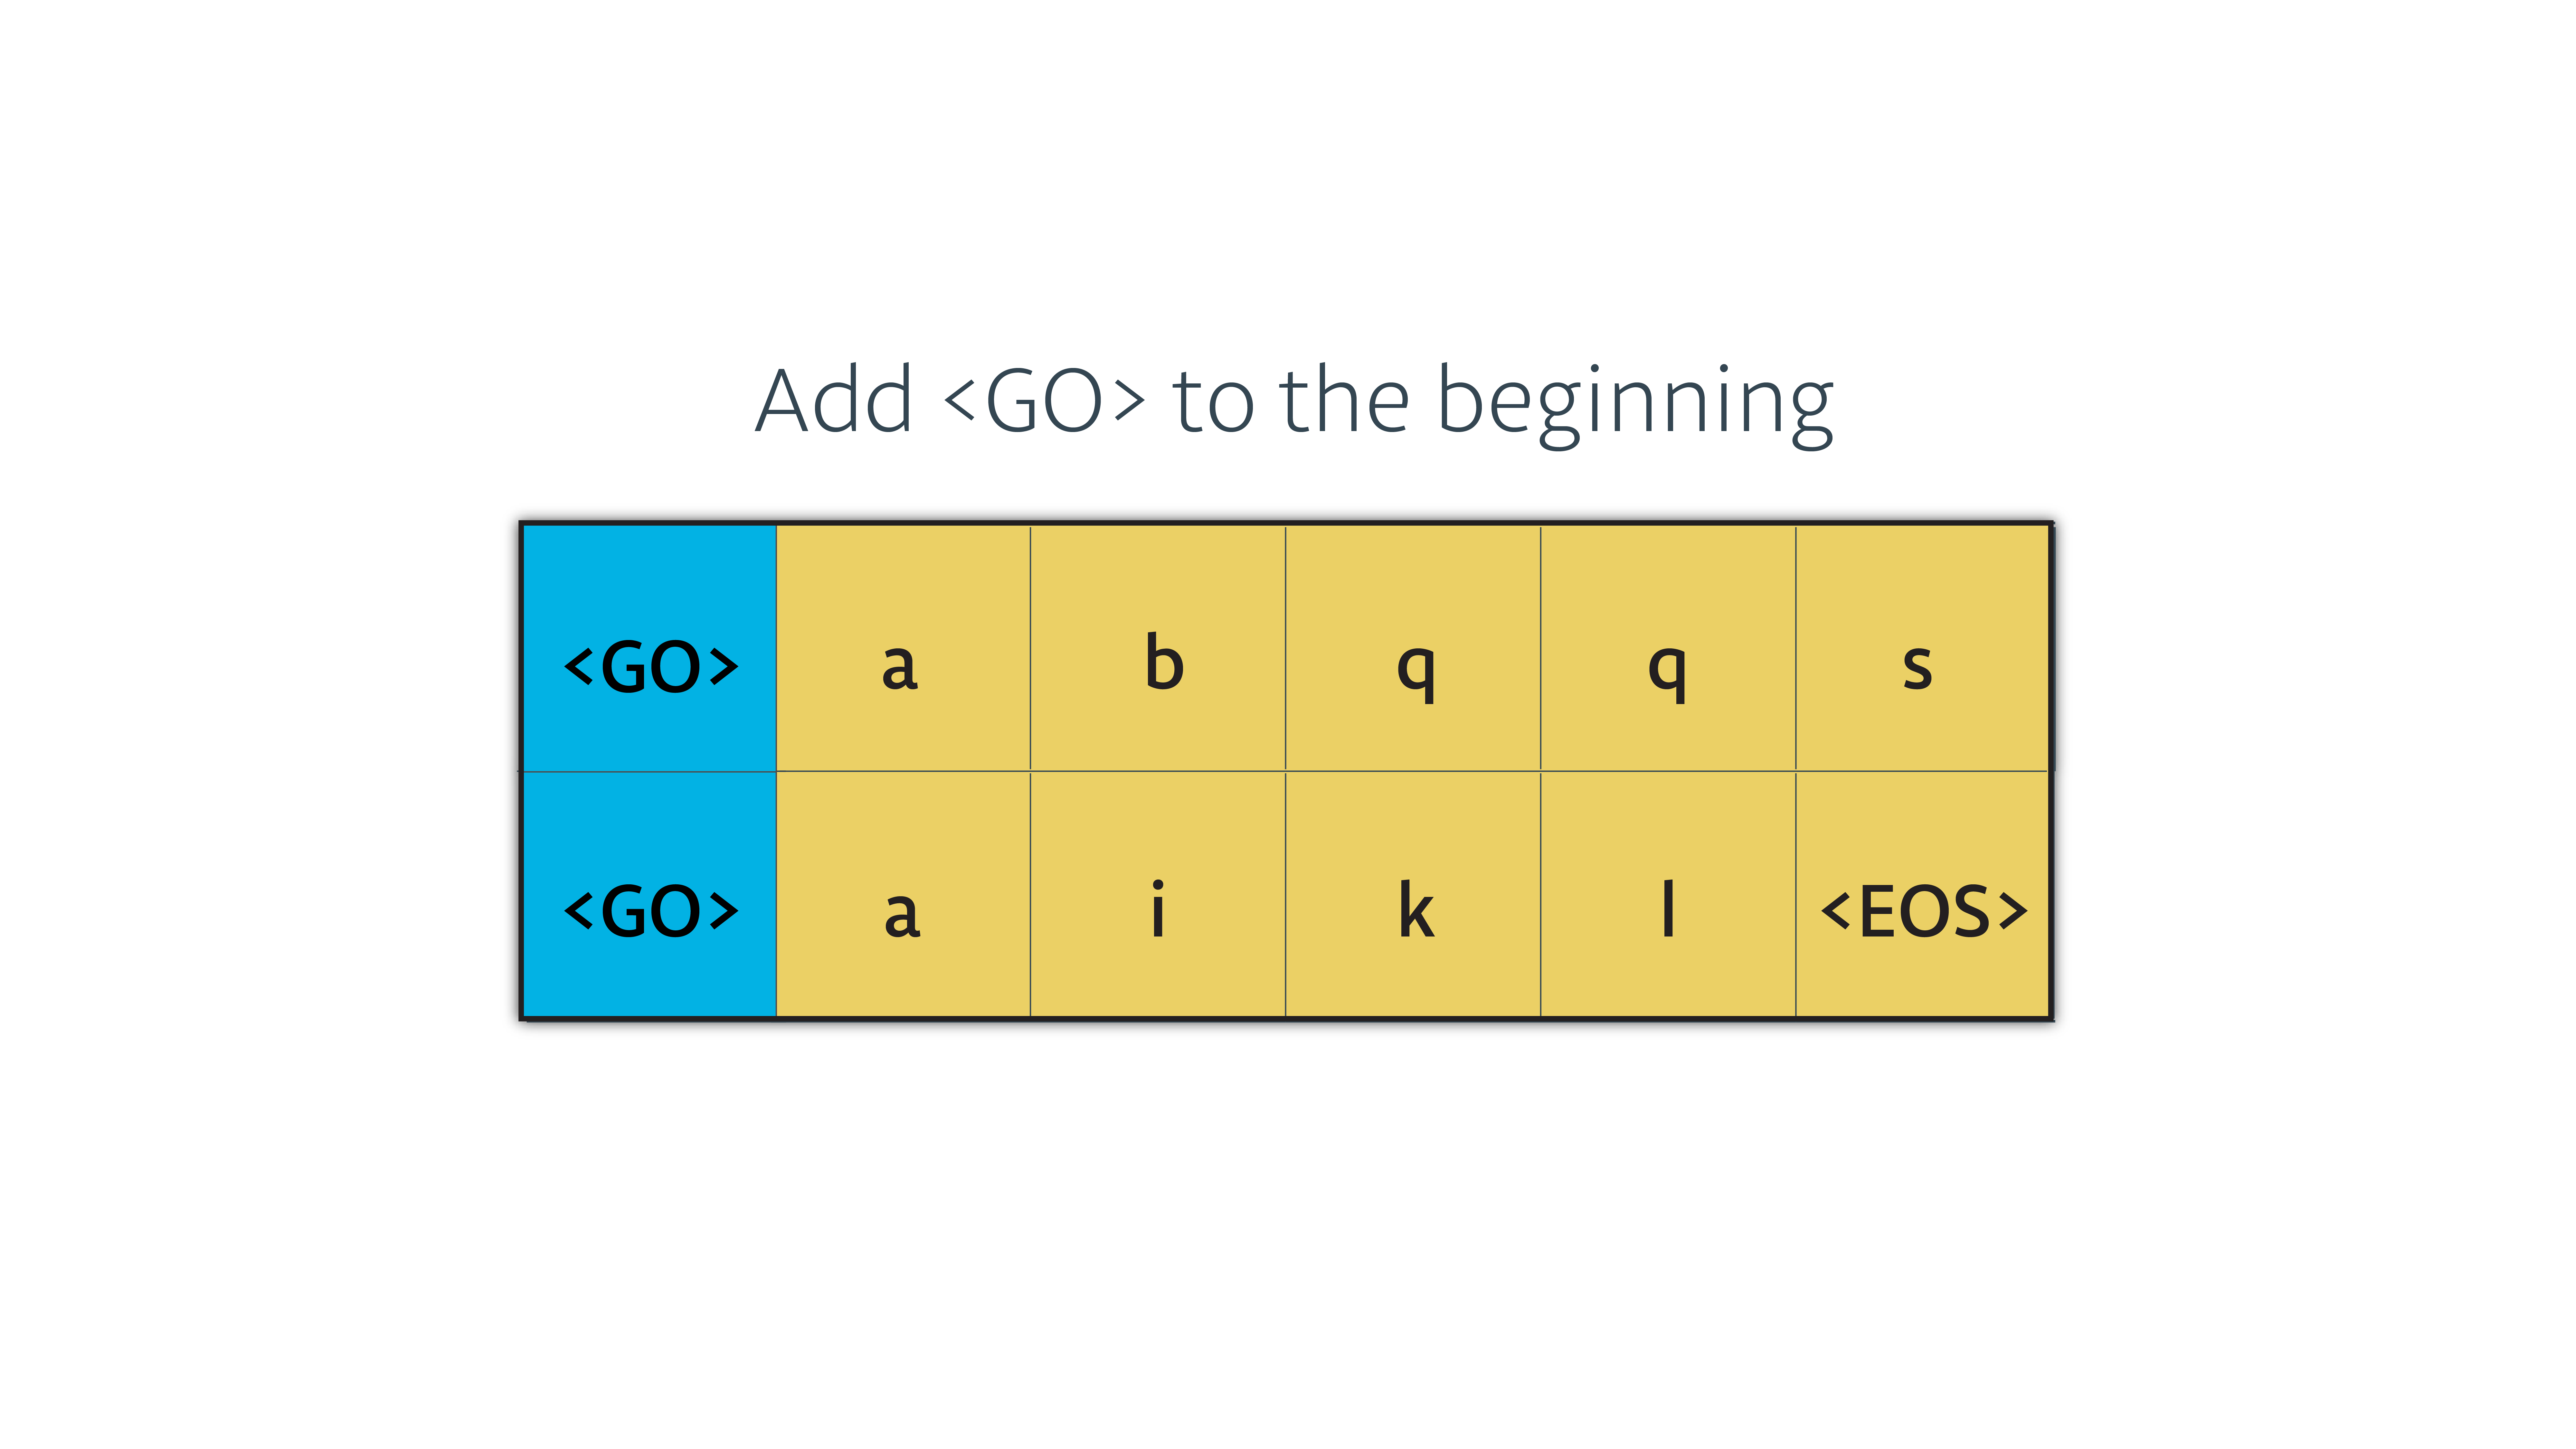

In [17]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/targets_add_go.png')

- 现在张量准备好传入解码器中，如下（在代码中，会将字母或符号转为整数id）:

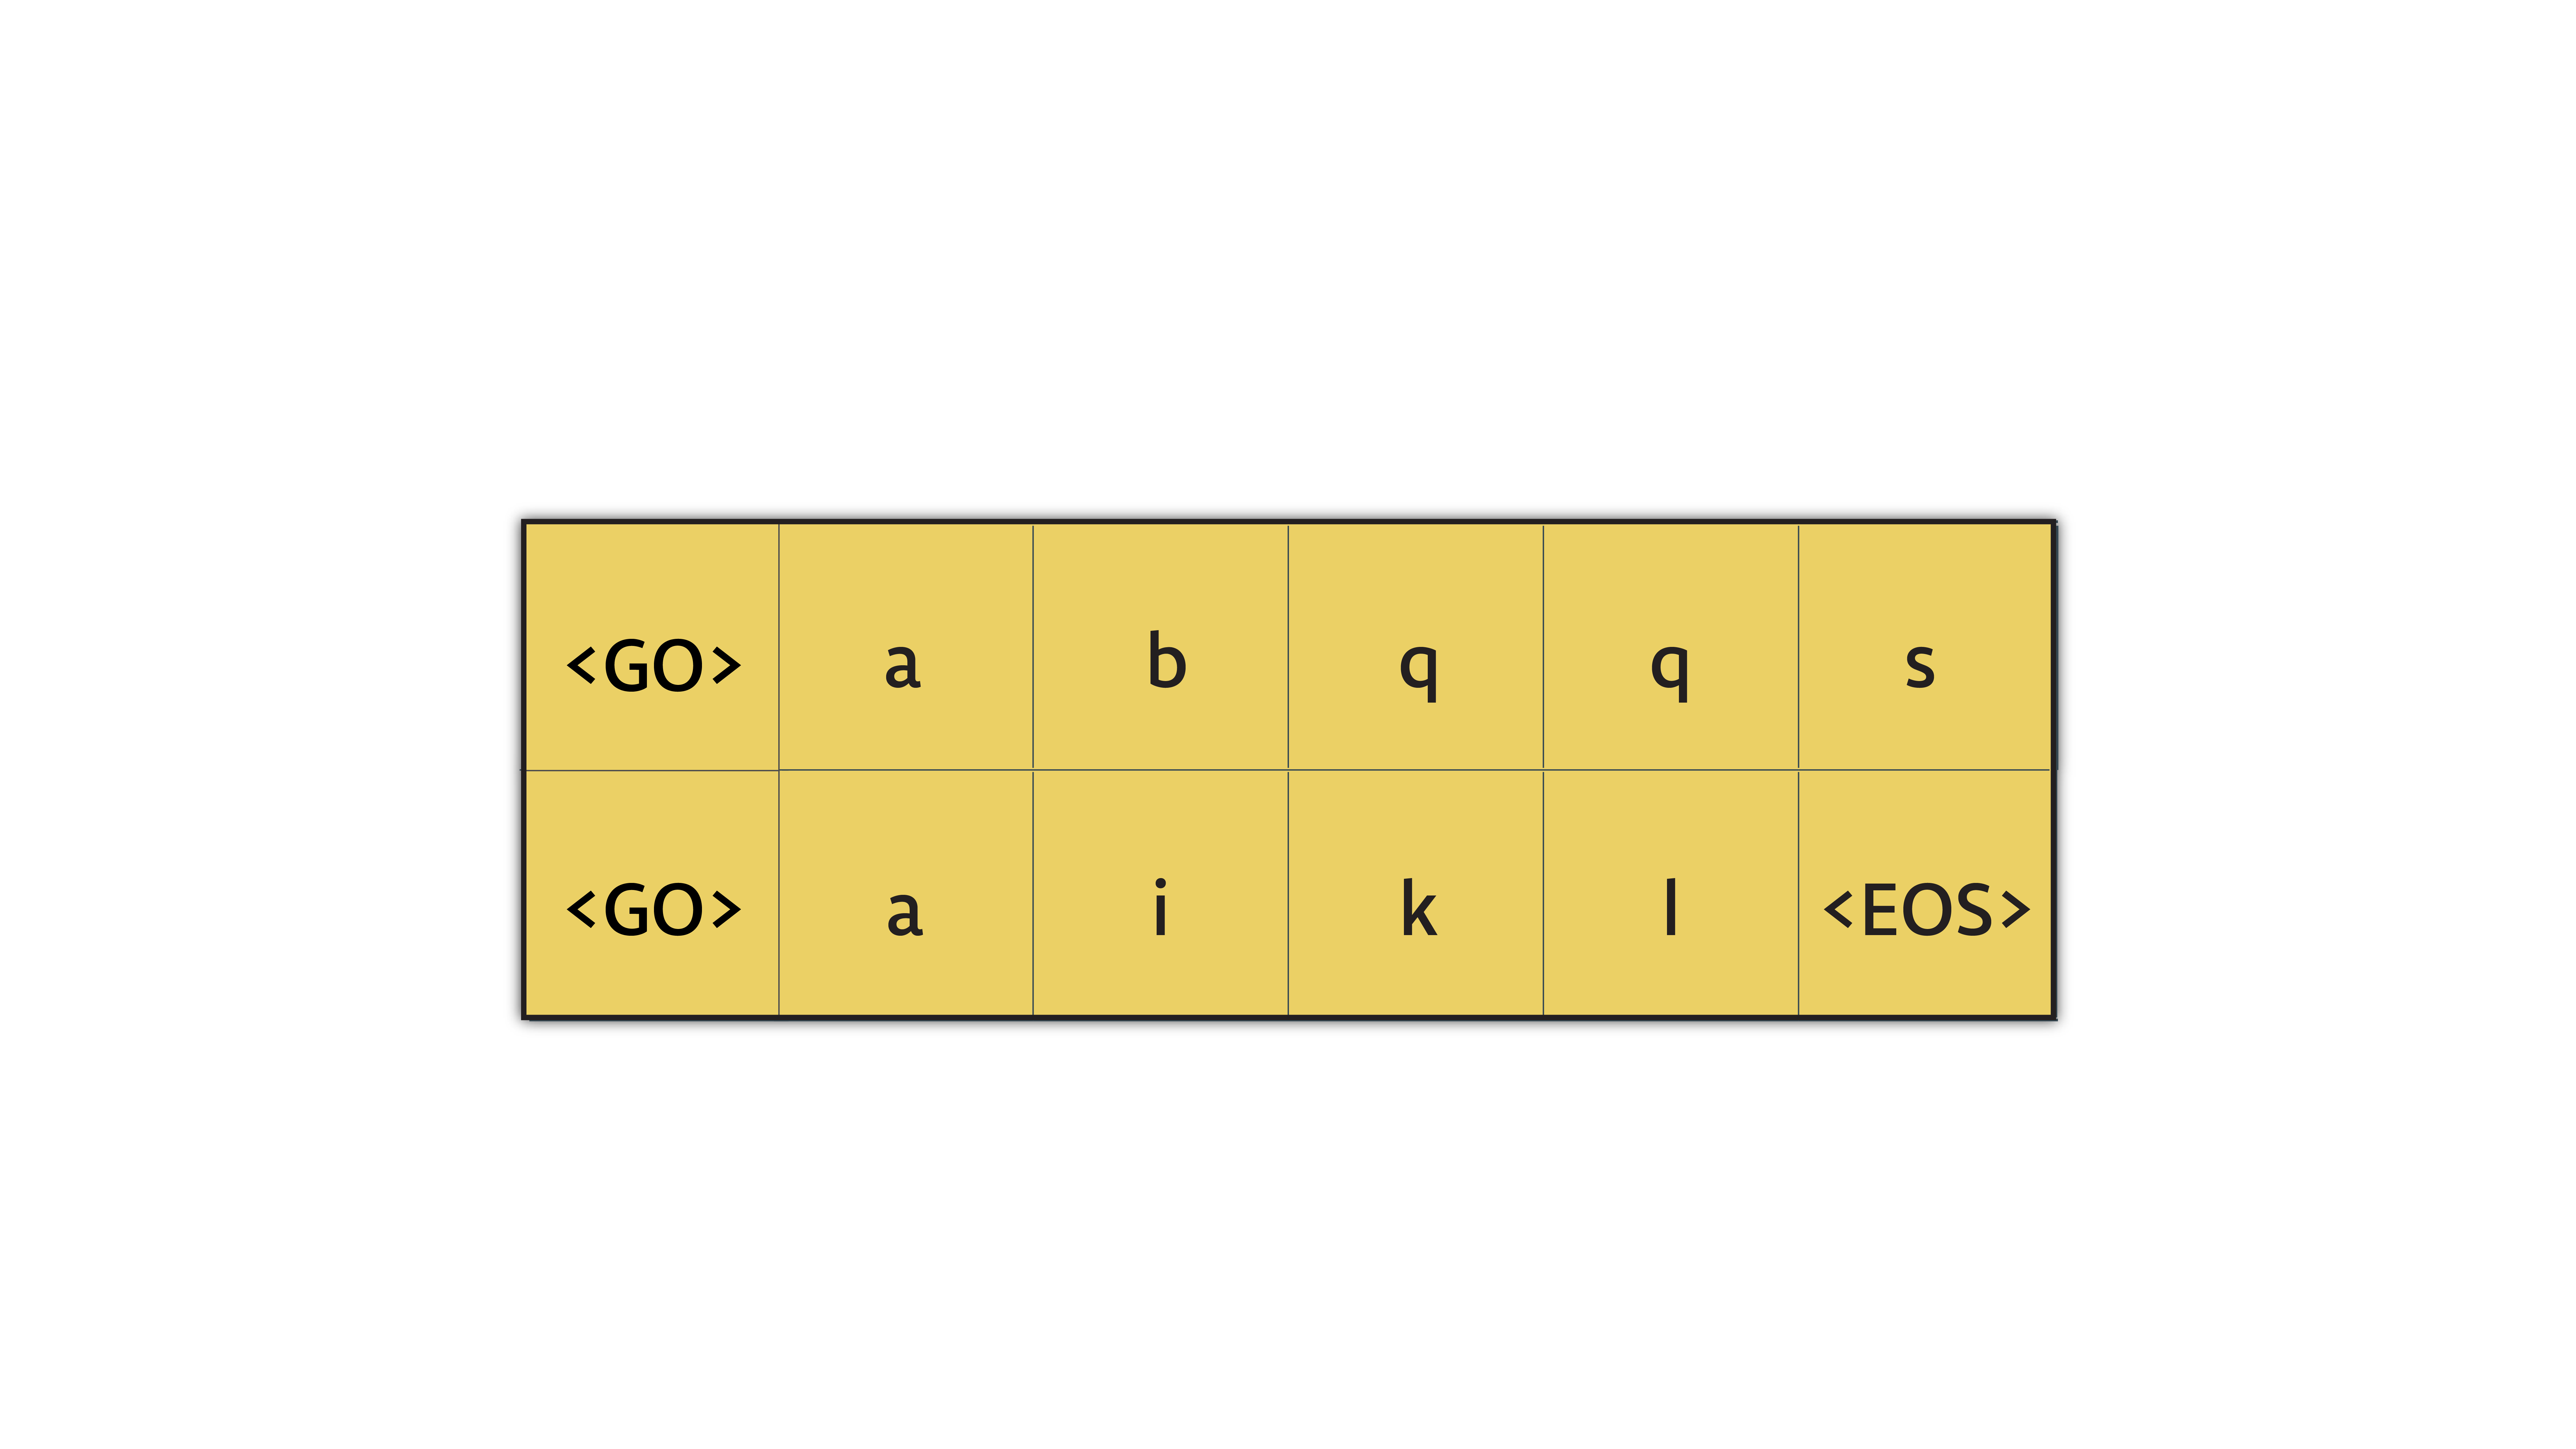

In [18]:
Image('https://github.com/udacity/deep-learning/raw/\
35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/targets_after_processing_1.png')

In [41]:
# 对目标序列进行处理，在传入解码器中
def process_decoder_input(target_data, vocab_to_int, batch_size):
    # 对每个 batch 移除最后一个词，并在开头添加 <GO>
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    # tf.fill(dims, value)参数会生成一个dims形状并用value填充的tensor
    # tf.fill([2,2], 7) => [[7,7], [7,7]]。tf.concat()会按照某个维度将两个tensor拼接起来
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

### 设置解码器组成部分

        - 对目标序列进行 embedding
        - 构造 decoder cell
        - 构造输出层，从而得到每个时间序列上的预测结果
        - Training decoder
        - Inference decoder

#### 1- embedding
　　对目标序列进行 embedding，然后传入解码器中。使用  tf.nn.embedding_lookup 将目标序列转为嵌入矩阵:

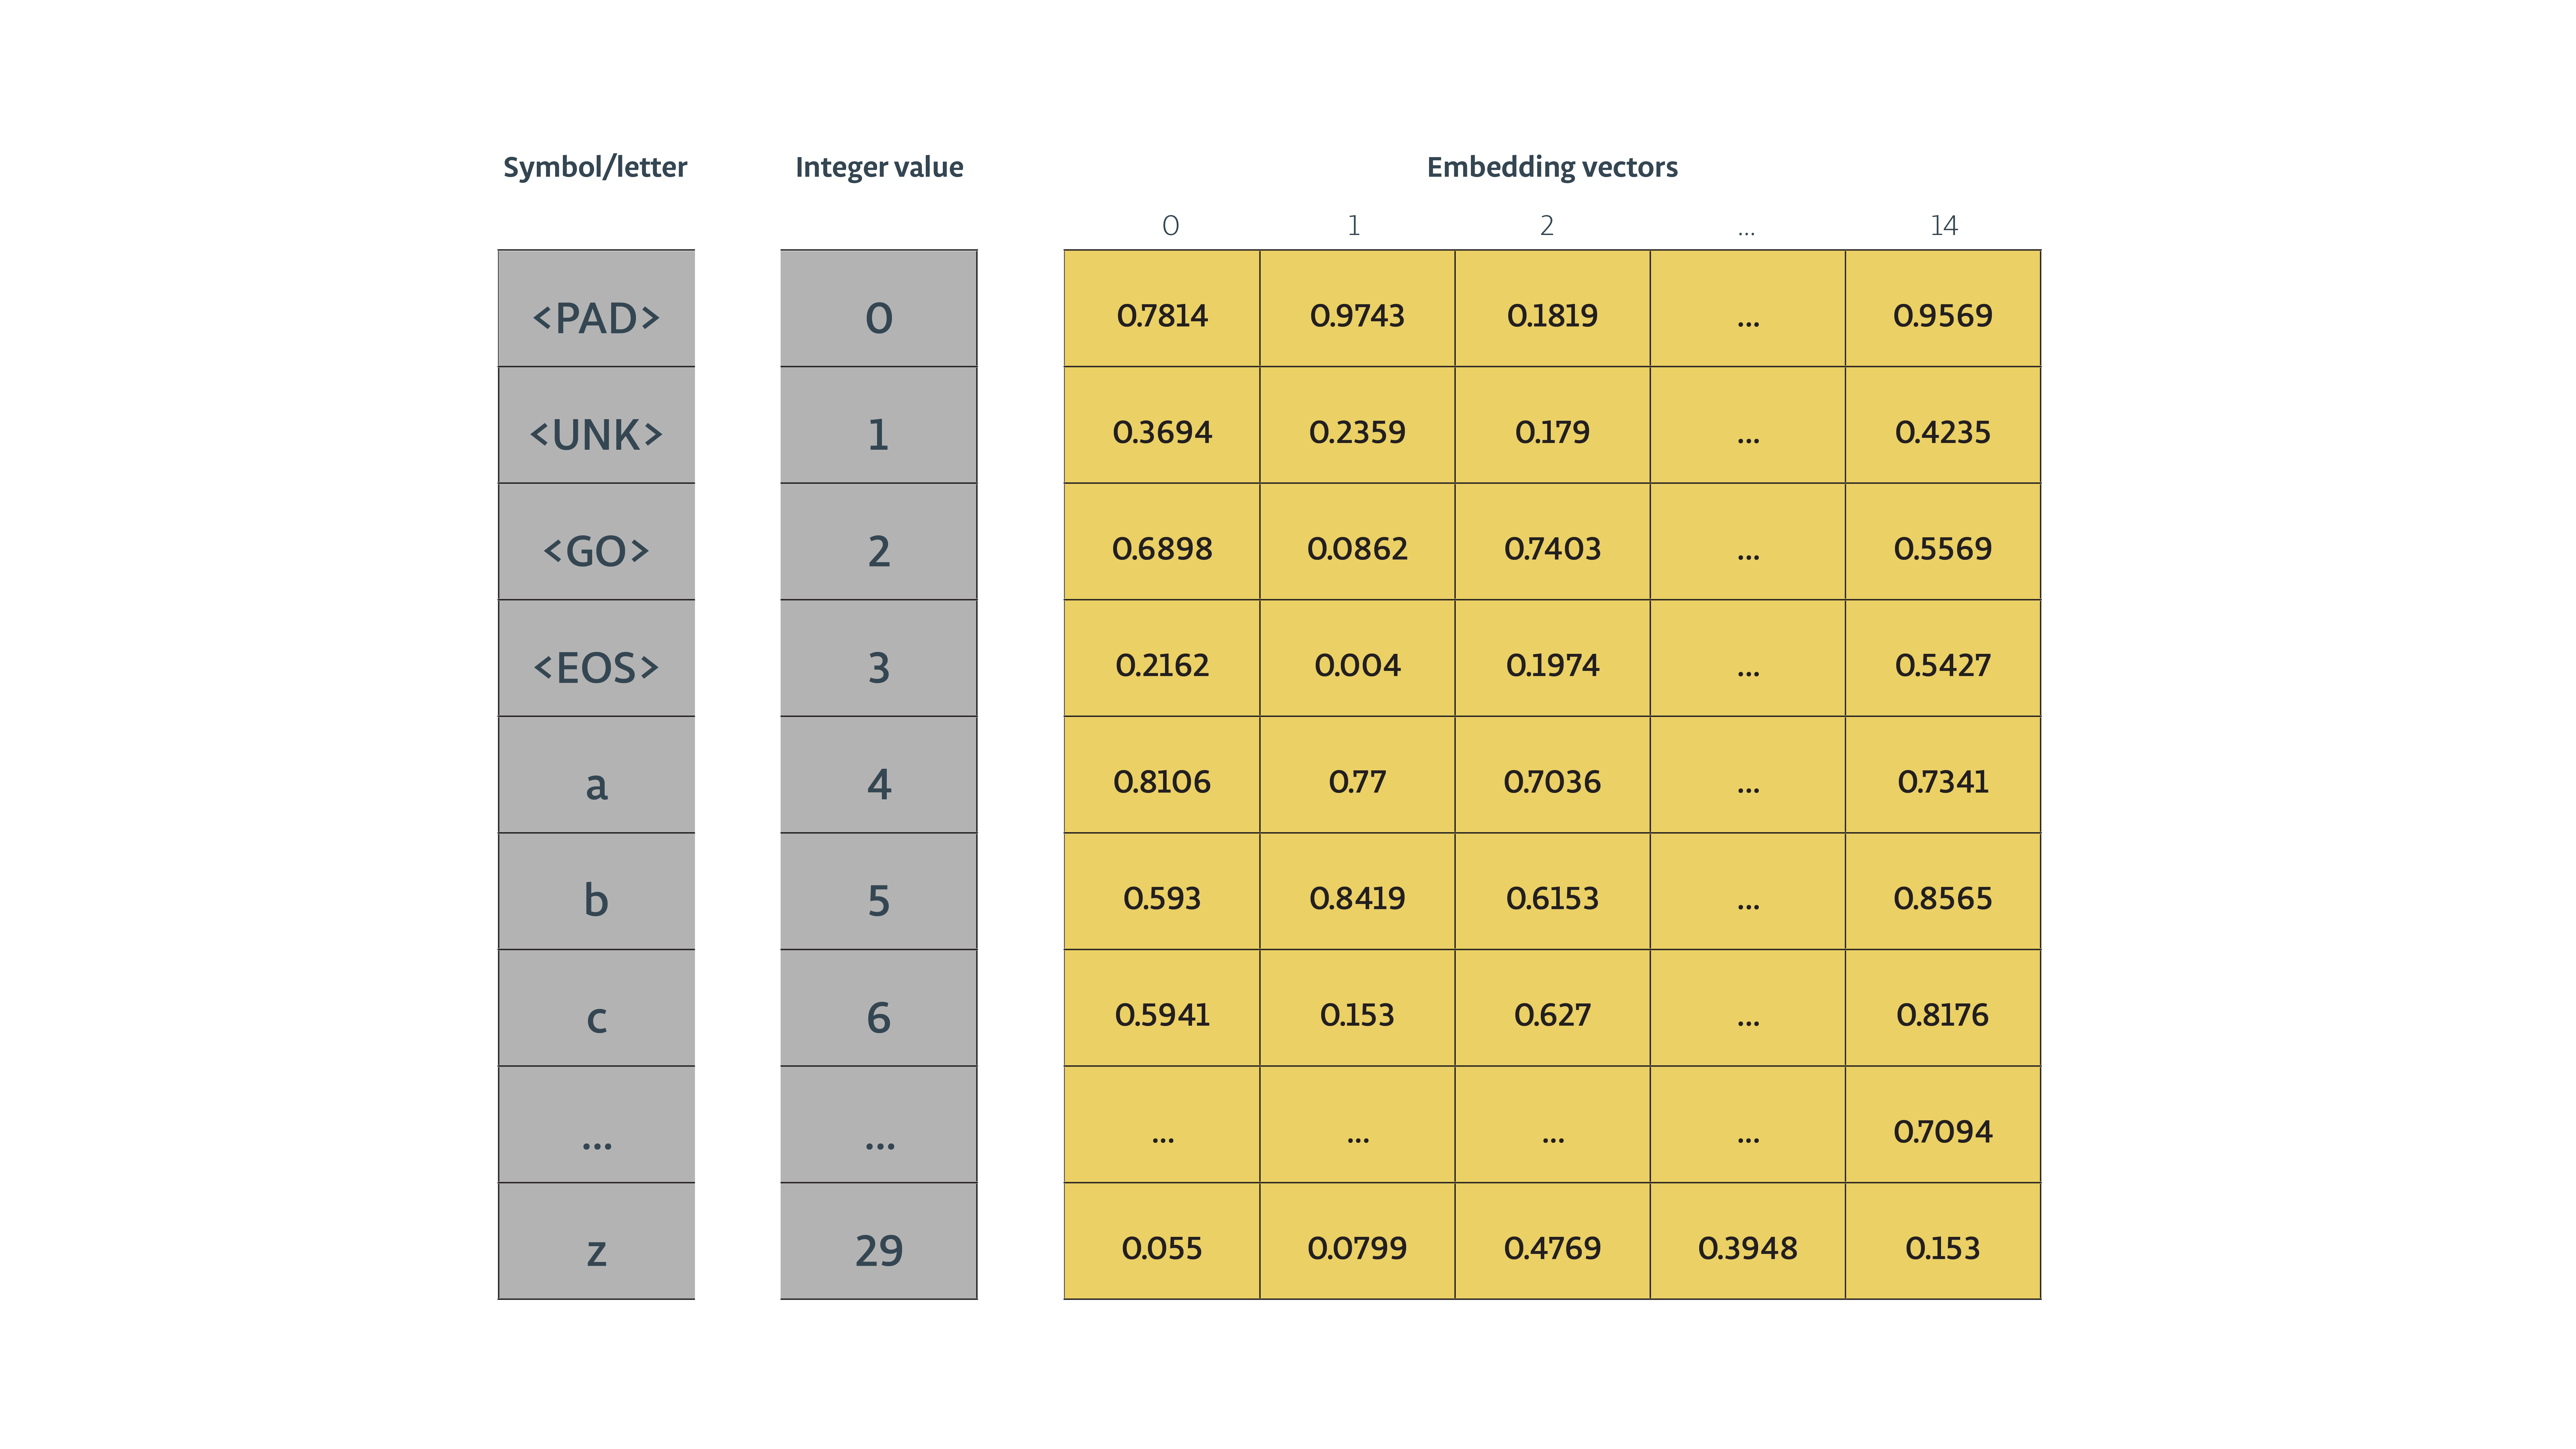

In [20]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/embeddings.png')

#### 2- decoder cell
　　使用 tf.contrib.rnn.LSTMCell 创建解码 cell。在训练过程中需要声明解码器，并为预测过程创建一个解码器。这两个解码器分别为 training decoder 和 inference decoder，将共享参数。即通过 training decoder 学习到的参数（权重和偏差），inference decoder 会拿来进行预测。首先，我们需要定义用于解码器RNN cell 的类型，这里使用 lstm。
　　
#### 3- 全连接输出层
　　创建输出层，这是一个全连接层，将解码器的输出转换为 logits，输出每个时间序列的RNN的输出结果

#### 4- training decoder
　　基本上，我们将创建两个共享参数的解码器。其中一个用于训练，另一个用于验证测试集。这两个非常相似，都使用 tf.contrib.seq2seq.**BasicDecoder** 和 tf.contrib.seq2seq.**dynamic_decode**。但有不同的地方，在训练阶段，为了能够让模型更加准确，我们并不会把 t-1 的预测输出作为 t 时刻的输入，而是直接使用目标序列中的 t 时刻的输入传到解码器中。而在预测阶段，没有目标序列，有的只是 t-1 时刻的输出和隐藏层的状态。这样做可以使得模型更加鲁棒。下图为 training decoder:

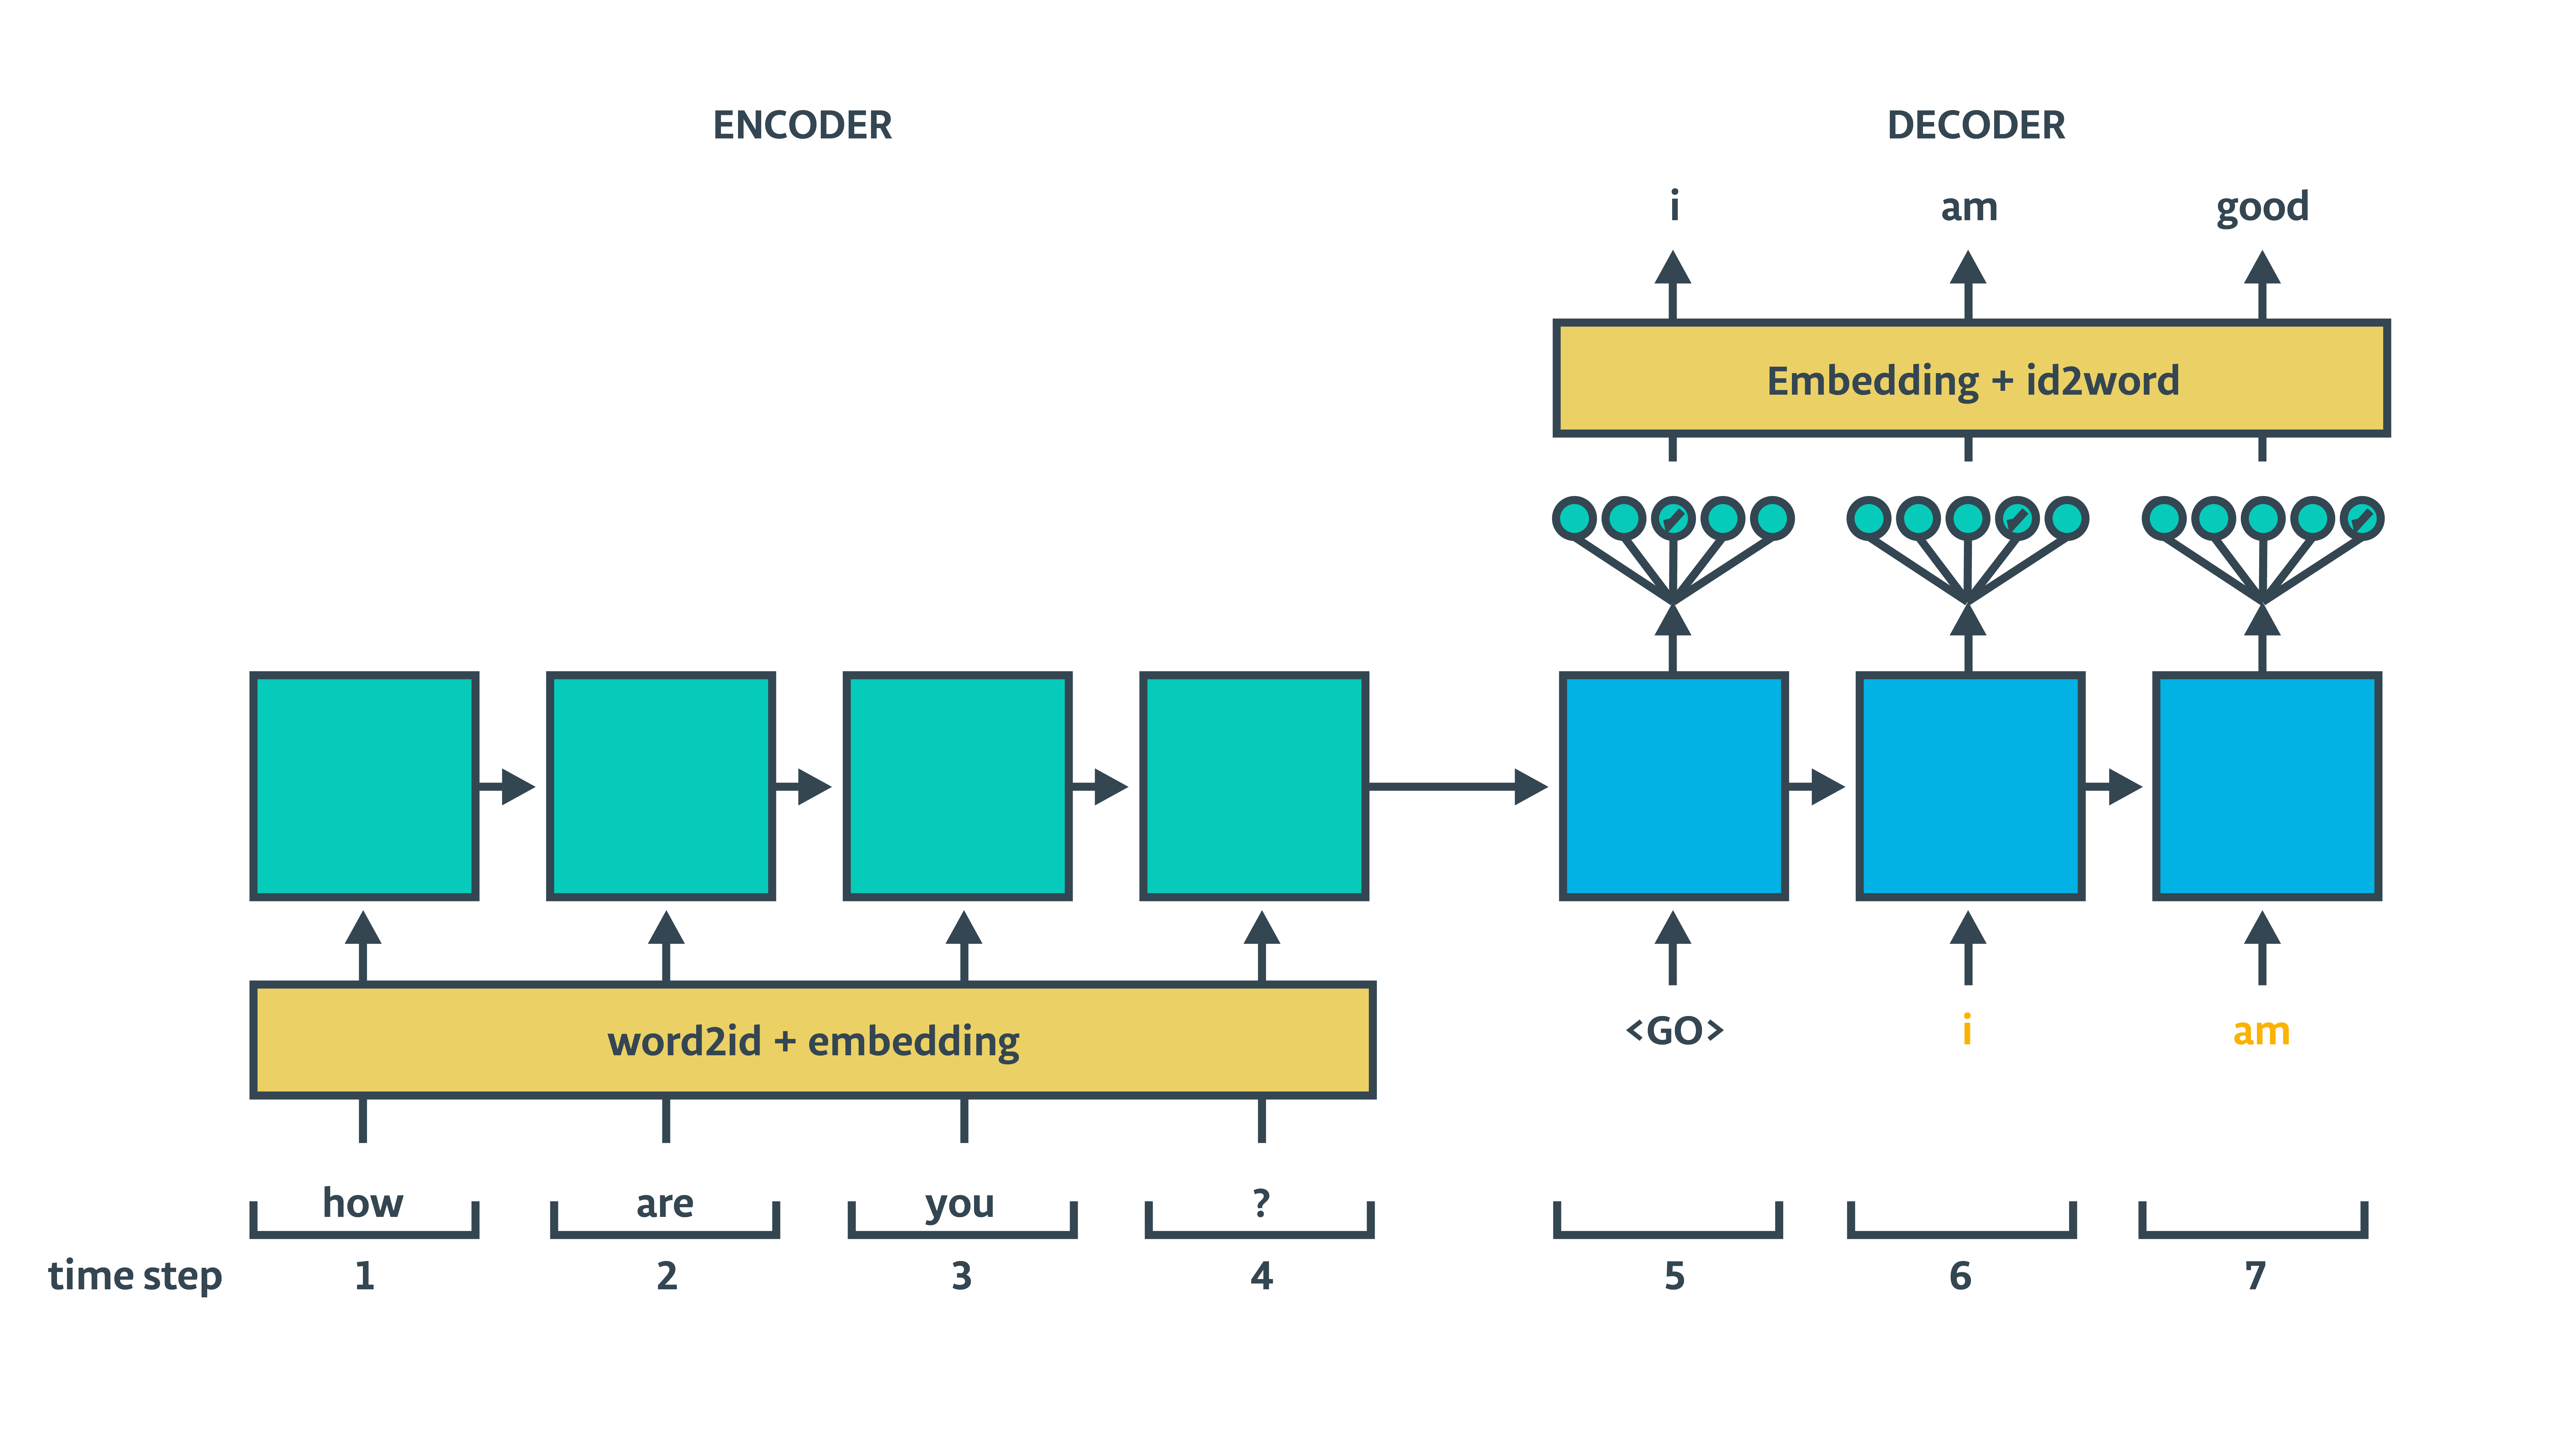

In [21]:
Image('https://github.com/udacity/deep-learning/raw/\
35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/sequence-to-sequence-training-decoder.png')

　　training decoder 不会将每个时间步长的预测输出作为下一个时刻的输入。相反，解码器的下一时刻的输入是来自训练数据集的目标序列（橙色字母），这样能保证模型更加准确。而在预测时，解码器的下一时刻的输入是来自先前时刻的预测输出，因为没有目标序列。
#### 5- inference decoder
　　下图为预测阶段，这时没有目标序列，所以使用先前时刻的预测输出作为下一时刻的输入。当然，inference decoder 虽然和 training decoder 是分开的，但它们是共享参数的。

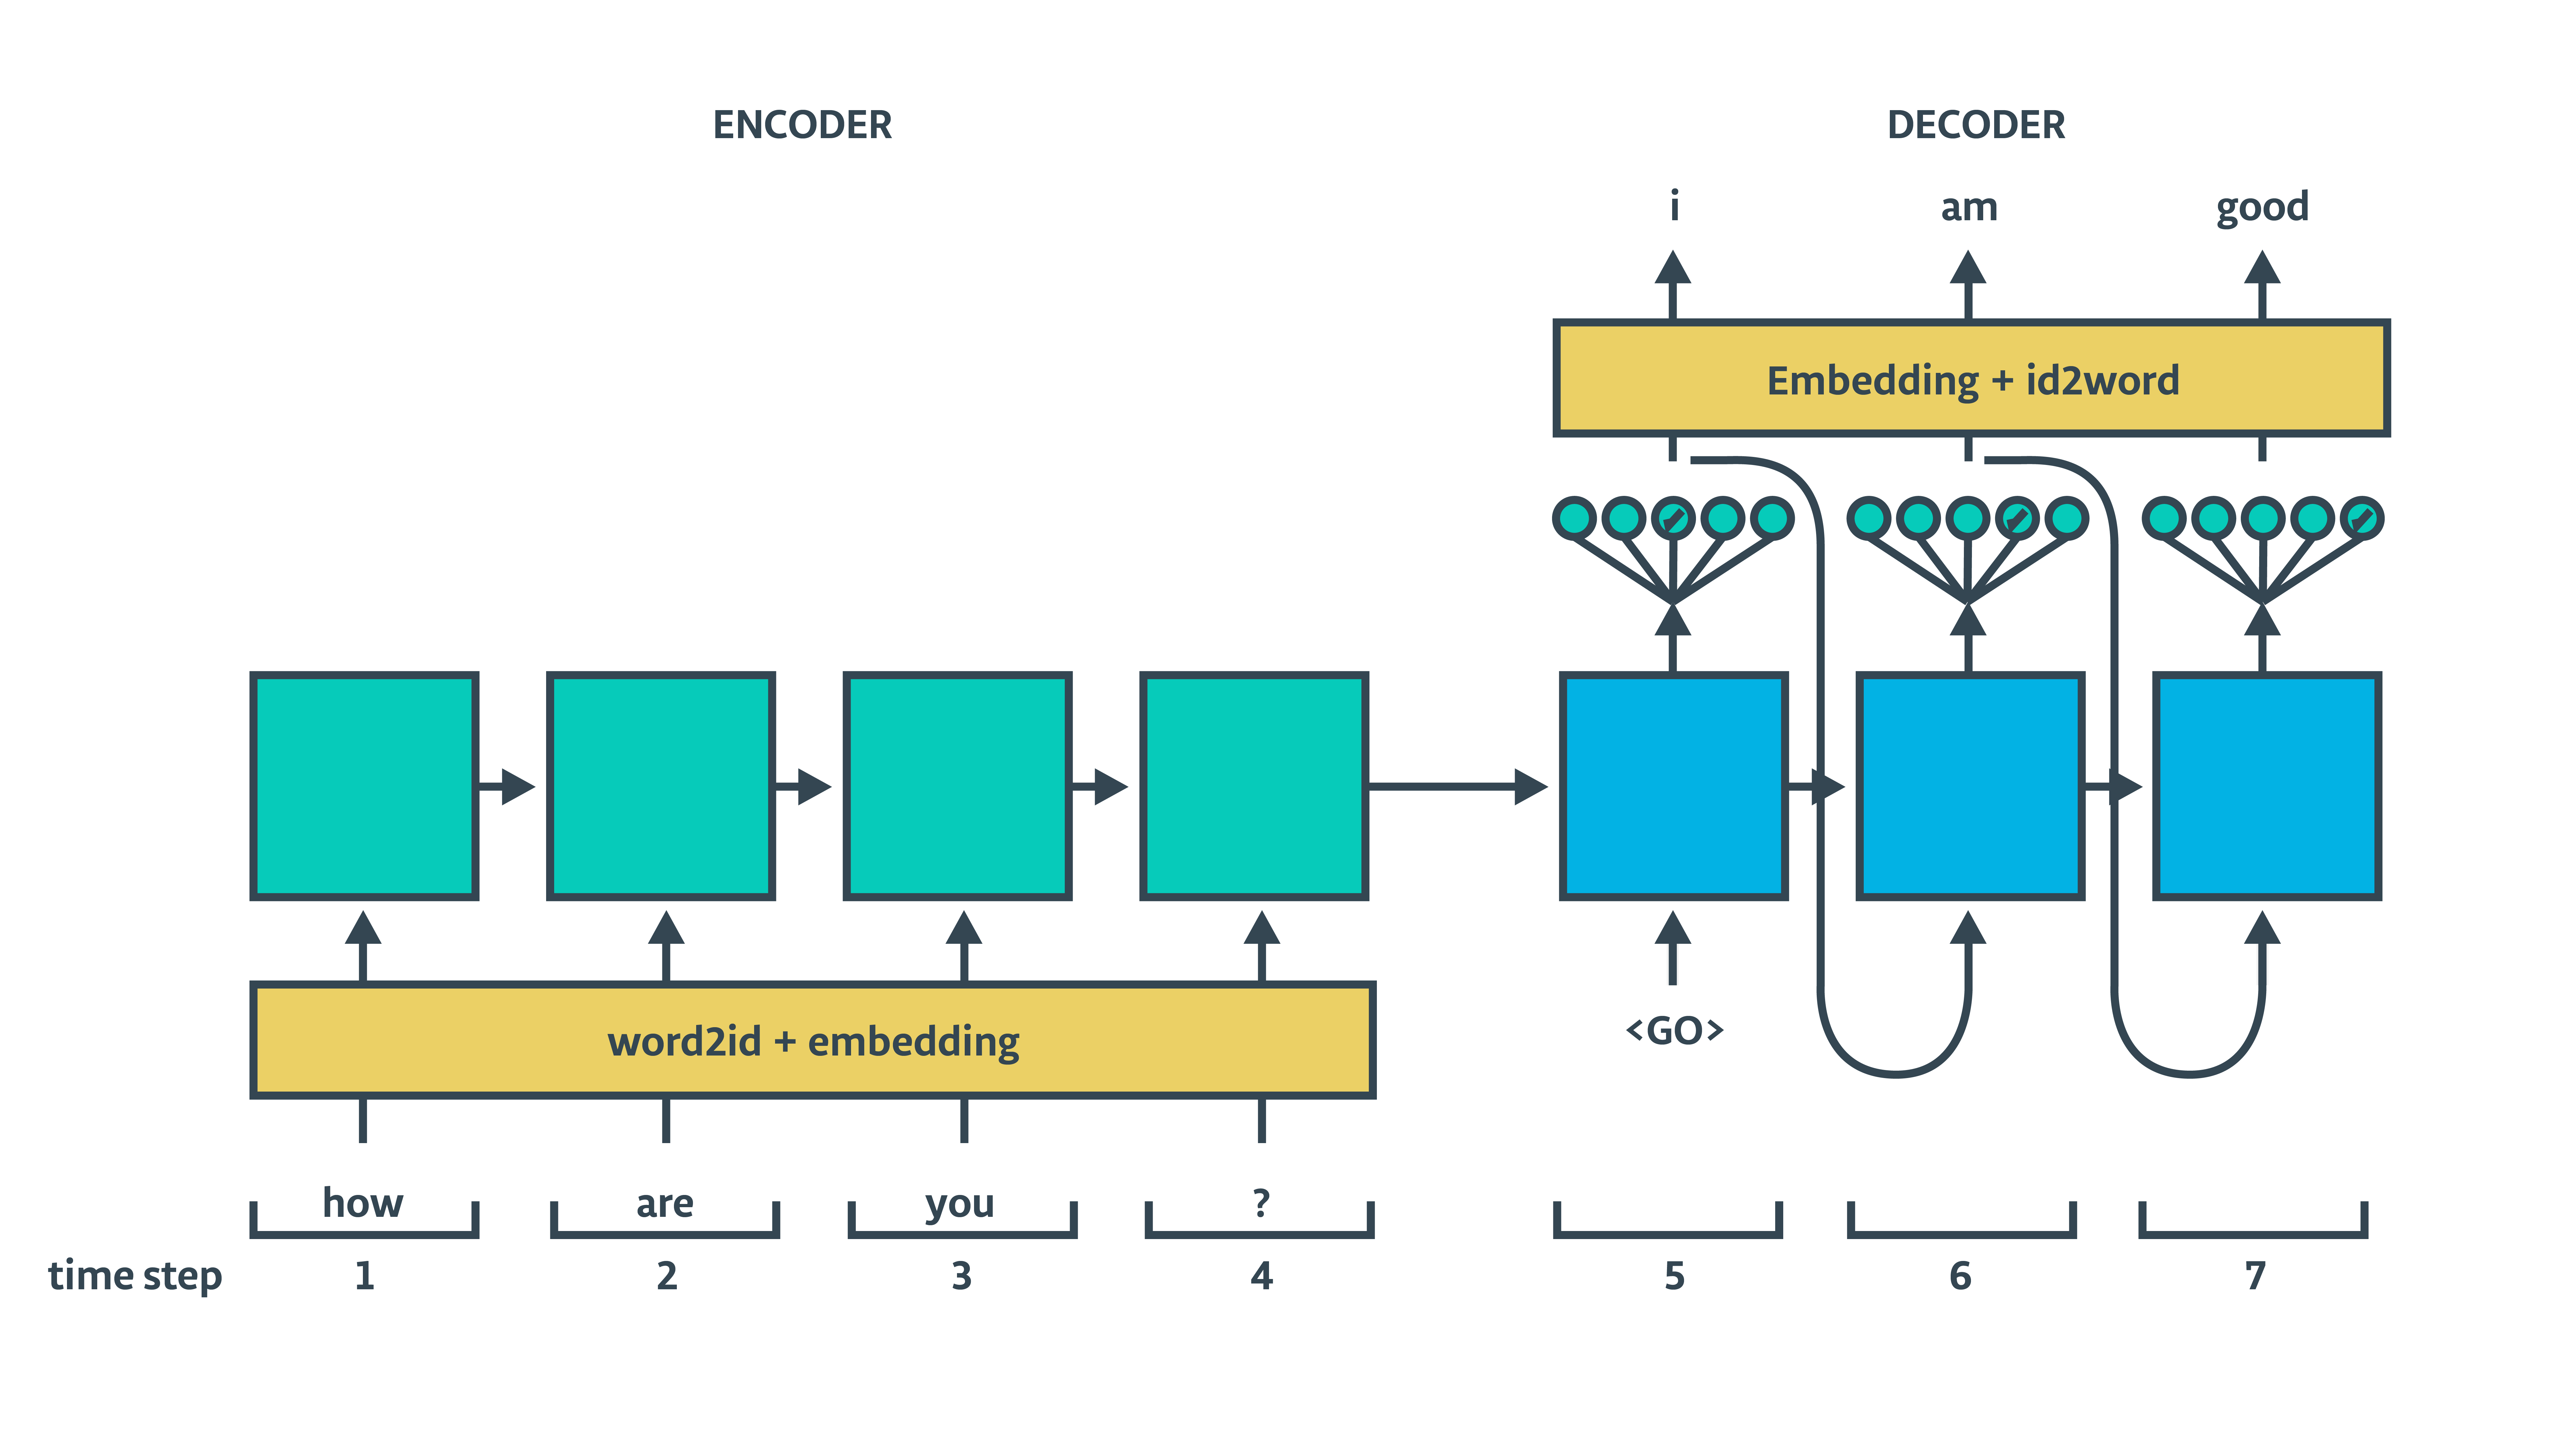

In [22]:
Image('https://github.com/udacity/deep-learning/raw/\
35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/sequence-to-sequence-inference-decoder.png')

In [43]:
def decoding_layer(target_letter_to_int, decoding_embedding_size, num_layers, rnn_size,
                   target_sequence_length, max_target_sequence_length, enc_state, dec_input):
    '''
    构造解码器
    Args:
        target_letter_to_int: 将目标序列从文本转为数字，即映射表
        decoding_embedding_size: embedding 大小
        num_layers: 堆叠的 RNN 神经元层数量
        rnn_size: RNN 神经元层的神经元数
        target_sequence_length: 目标序列的长度
        max_target_sequence_length: 目标序列的最大长度
        enc_state: 编码器的编码状态向量
        dec_input: 解码器的输入
    '''
    # embedding
    target_vocab_size = len(target_letter_to_int)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    # 构建 decoder cell
    def make_cell(rnn_size):
        dec_cell = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return dec_cell
    # 使用 num-layers 构建多层 cell
    dec_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
    
    # 全连接层将每个时间步长的解码器的输出转为词汇表中的选择
    output_layer = Dense(target_vocab_size, kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))

    # 设置 training decode 和 inference decoder
    # training decode
    with tf.variable_scope('decode'):
        # 得到 helper
        training_helper = tf.contrib.seq2seq.TrainingHelper(
                                                            # 嵌入矩阵
                                                            inputs=dec_embed_input,
                                                            # 当前batch中每个序列的长度
                                                            sequence_length=target_sequence_length,
                                                            # 为False，则输入为 [batch_size, sequence_length, embedding_size]
                                                            # 为True，则输入为 [sequence_length, batch_size, embedding_size
                                                            time_major=False)
        
        # Basic decoder
        # BasicDecoder的作用就是定义一个封装了decoder应该有的功能的实例，根据Helper实例的不同，这个decoder
        #可以实现不同的功能，比如在train的阶段，不把输出重新作为输入，而在inference阶段，将输出接到输入
        training_decoder = tf.contrib.seq2seq.BasicDecoder(
                                                            # 多层 cell
                                                            dec_cell,
                                                            # helper 实例
                                                           training_helper,
                                                            # encoder的final state，类型要一致，也就是说如果encoder的final state是tuple类型
                                                            # 那么这里的输入也必须是tuple
                                                           enc_state,
                                                            # 对应的是全连接层
                                                           output_layer) 

        # 使用解码器执行解码
        training_decoder_output = tf.contrib.seq2seq.dynamic_decode(
                                                                       training_decoder,
                                                                       impute_finished=True,
                                                                       maximum_iterations=max_target_sequence_length)[0]
    # inference Decoder
    # 与 training decode 共享参数
    with tf.variable_scope('decode', reuse=True):
        # 创建一个常量 tensor 并复制为 batch_size 的大小
        start_tokens = tf.tile(tf.constant([target_letter_to_int['<GO>']], dtype=tf.int32), [batch_size], name='start_tokens')
        
        # 这是用于inference阶段的helper，将output输出后的logits使用argmax获得id再经过embedding layer来获取下一时刻的输入。
        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                                                                dec_embeddings,
                                                                # batch中每个序列起始输入的token_id , 这里为 '<GO>'
                                                                start_tokens,
                                                                # 序列终止的token_id
                                                                target_letter_to_int['<EOS>'])
        
        # Basic decoder
        inference_decoder = tf.contrib.seq2seq.BasicDecoder(
                                                        dec_cell,
                                                        inference_helper,
                                                        enc_state,
                                                        output_layer)
        
        # Perform dynamic decoding using the decoder
        inference_decoder_output = tf.contrib.seq2seq.dynamic_decode(
                                                            inference_decoder,
                                                            impute_finished=True,
                                                            maximum_iterations=max_target_sequence_length)[0]
         
    return training_decoder_output, inference_decoder_output

## 2.3 Seq2seq 模型
　　将编码器和解码器连接起来。

In [44]:
def seq2seq_model(input_data, targets, lr, target_sequence_length, 
                  max_target_sequence_length, source_sequence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size, 
                  rnn_size, num_layers):
        
    # 将输入数据传到编码器，忽视编码器的输出，而使用其隐藏层状态输出
    _, enc_state = encoding_layer(input_data, 
                                  rnn_size, 
                                  num_layers, 
                                  source_sequence_length,
                                  source_vocab_size, 
                                  encoding_embedding_size)
    
    # 对目标序列进行预处理，并传给解码器
    dec_input = process_decoder_input(targets, target_letter_to_int, batch_size)
    
    # 将编码器的隐藏层状态向量和解码器的输入（目标序列）传到解码器
    training_decoder_output, inference_decoder_output = decoding_layer(target_letter_to_int, 
                                                                       decoding_embedding_size, 
                                                                       num_layers, 
                                                                       rnn_size,
                                                                       target_sequence_length,
                                                                       max_target_sequence_length,
                                                                       enc_state, 
                                                                       dec_input) 
    
    return training_decoder_output, inference_decoder_output

　　模型的输出 *training_decoder_output* 和 *inference_decoder_output*  都包含一个 'rnn_output' logits 张量，如下:

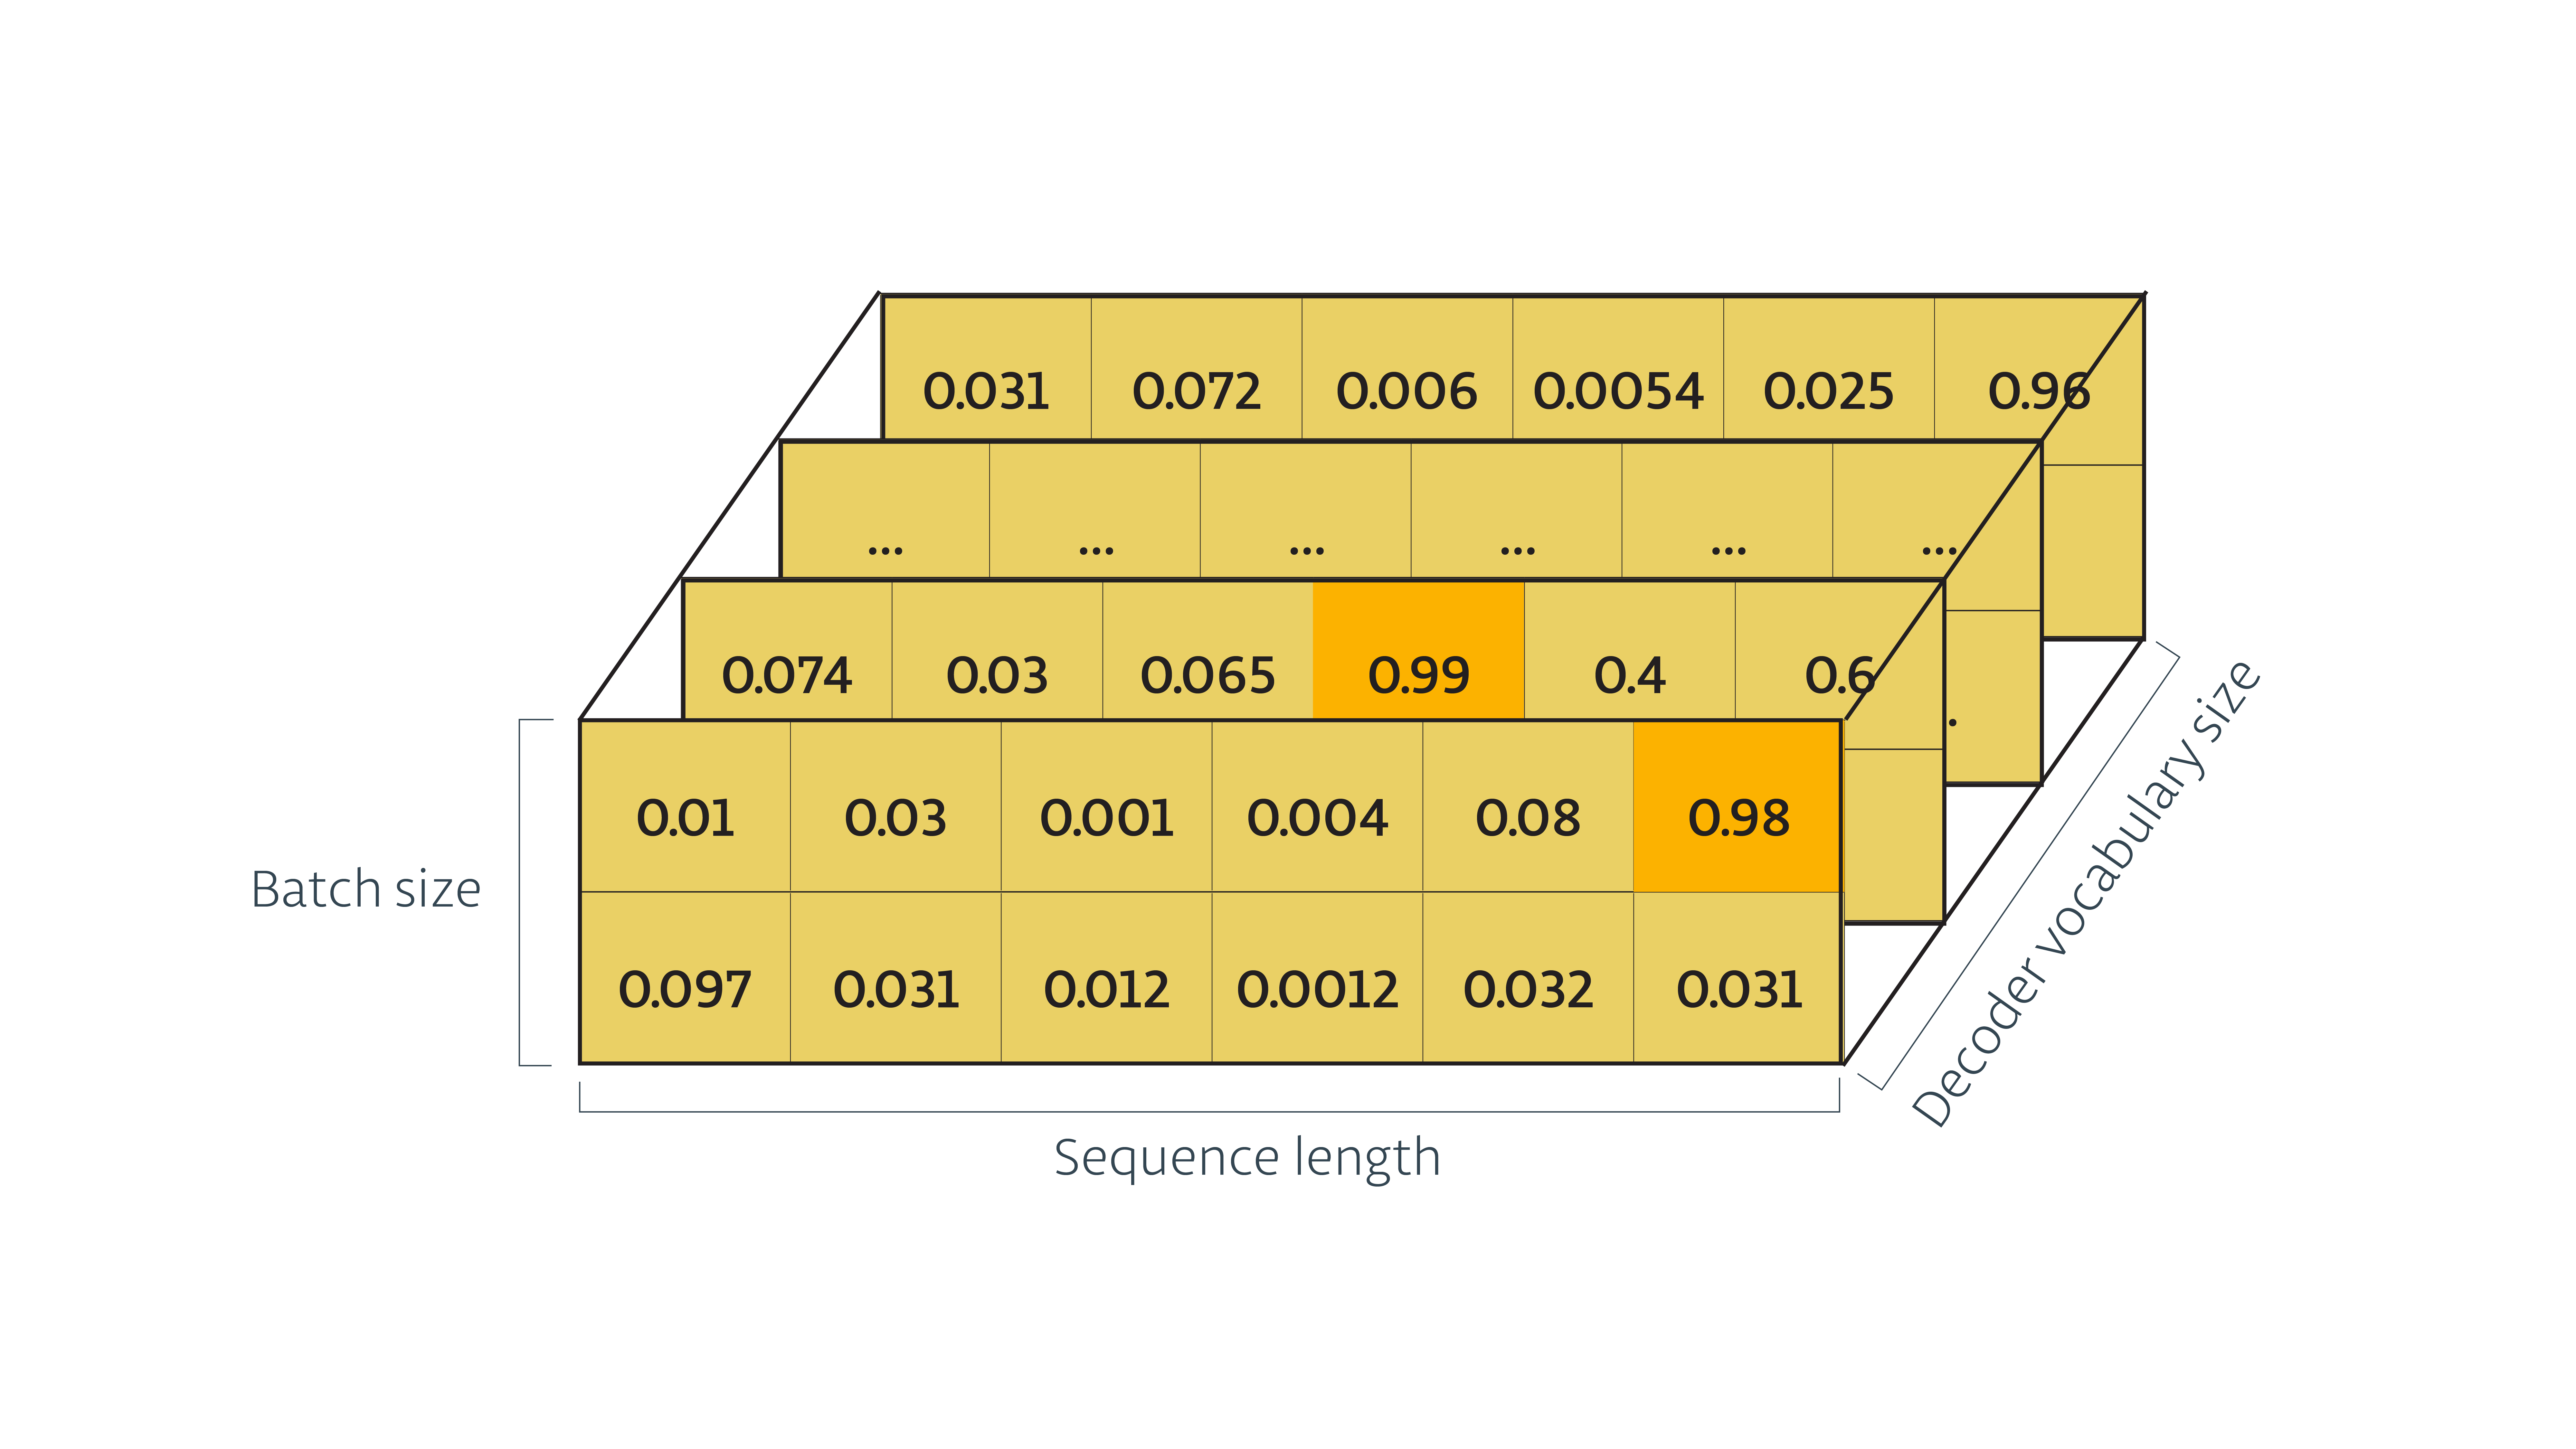

In [25]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/logits.png')

　　从训练张量得到的 logits 将传递给  tf.contrib.seq2seq.**sequence_loss()** 用于计算损失和梯度。

In [46]:
# 建立 graph
train_graph = tf.Graph()
with train_graph.as_default():
    # 载入模型输入
    input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length = get_model_inputs()
    # 创建 training 和 inference logits
    training_decoder_output, inference_decoder_output = seq2seq_model(input_data, 
                                                                      targets, 
                                                                      lr, 
                                                                      target_sequence_length, 
                                                                      max_target_sequence_length, 
                                                                      source_sequence_length,
                                                                      len(source_letter_to_int),
                                                                      len(target_letter_to_int),
                                                                      encoding_embedding_size, 
                                                                      decoding_embedding_size, 
                                                                      rnn_size, 
                                                                      num_layers)  
    
    # 为 training logits 和 inference logits 创建张量
    training_logits = tf.identity(training_decoder_output.rnn_output, 'logits')
    inference_logits = tf.identity(inference_decoder_output.sample_id, name='predictions')
    
    # 为 sequence_loss 创建权重
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope('optimization'):
        
        # 损失函数
        cost = tf.contrib.seq2seq.sequence_loss(
                                        training_logits,
                                        targets,
                                        masks)
        
        # 优化方法
        optimizer = tf.train.AdamOptimizer(lr)

        # 梯度裁剪，防止梯度爆炸或梯度消失
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5.0, 5.0), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

## 获得 Batches
　　当我们检索 batches，涉及的处理很少。下面的例子为 batch_size = 2 的源序列（实际为整数形式，这里使用字符串形式便于展示）:

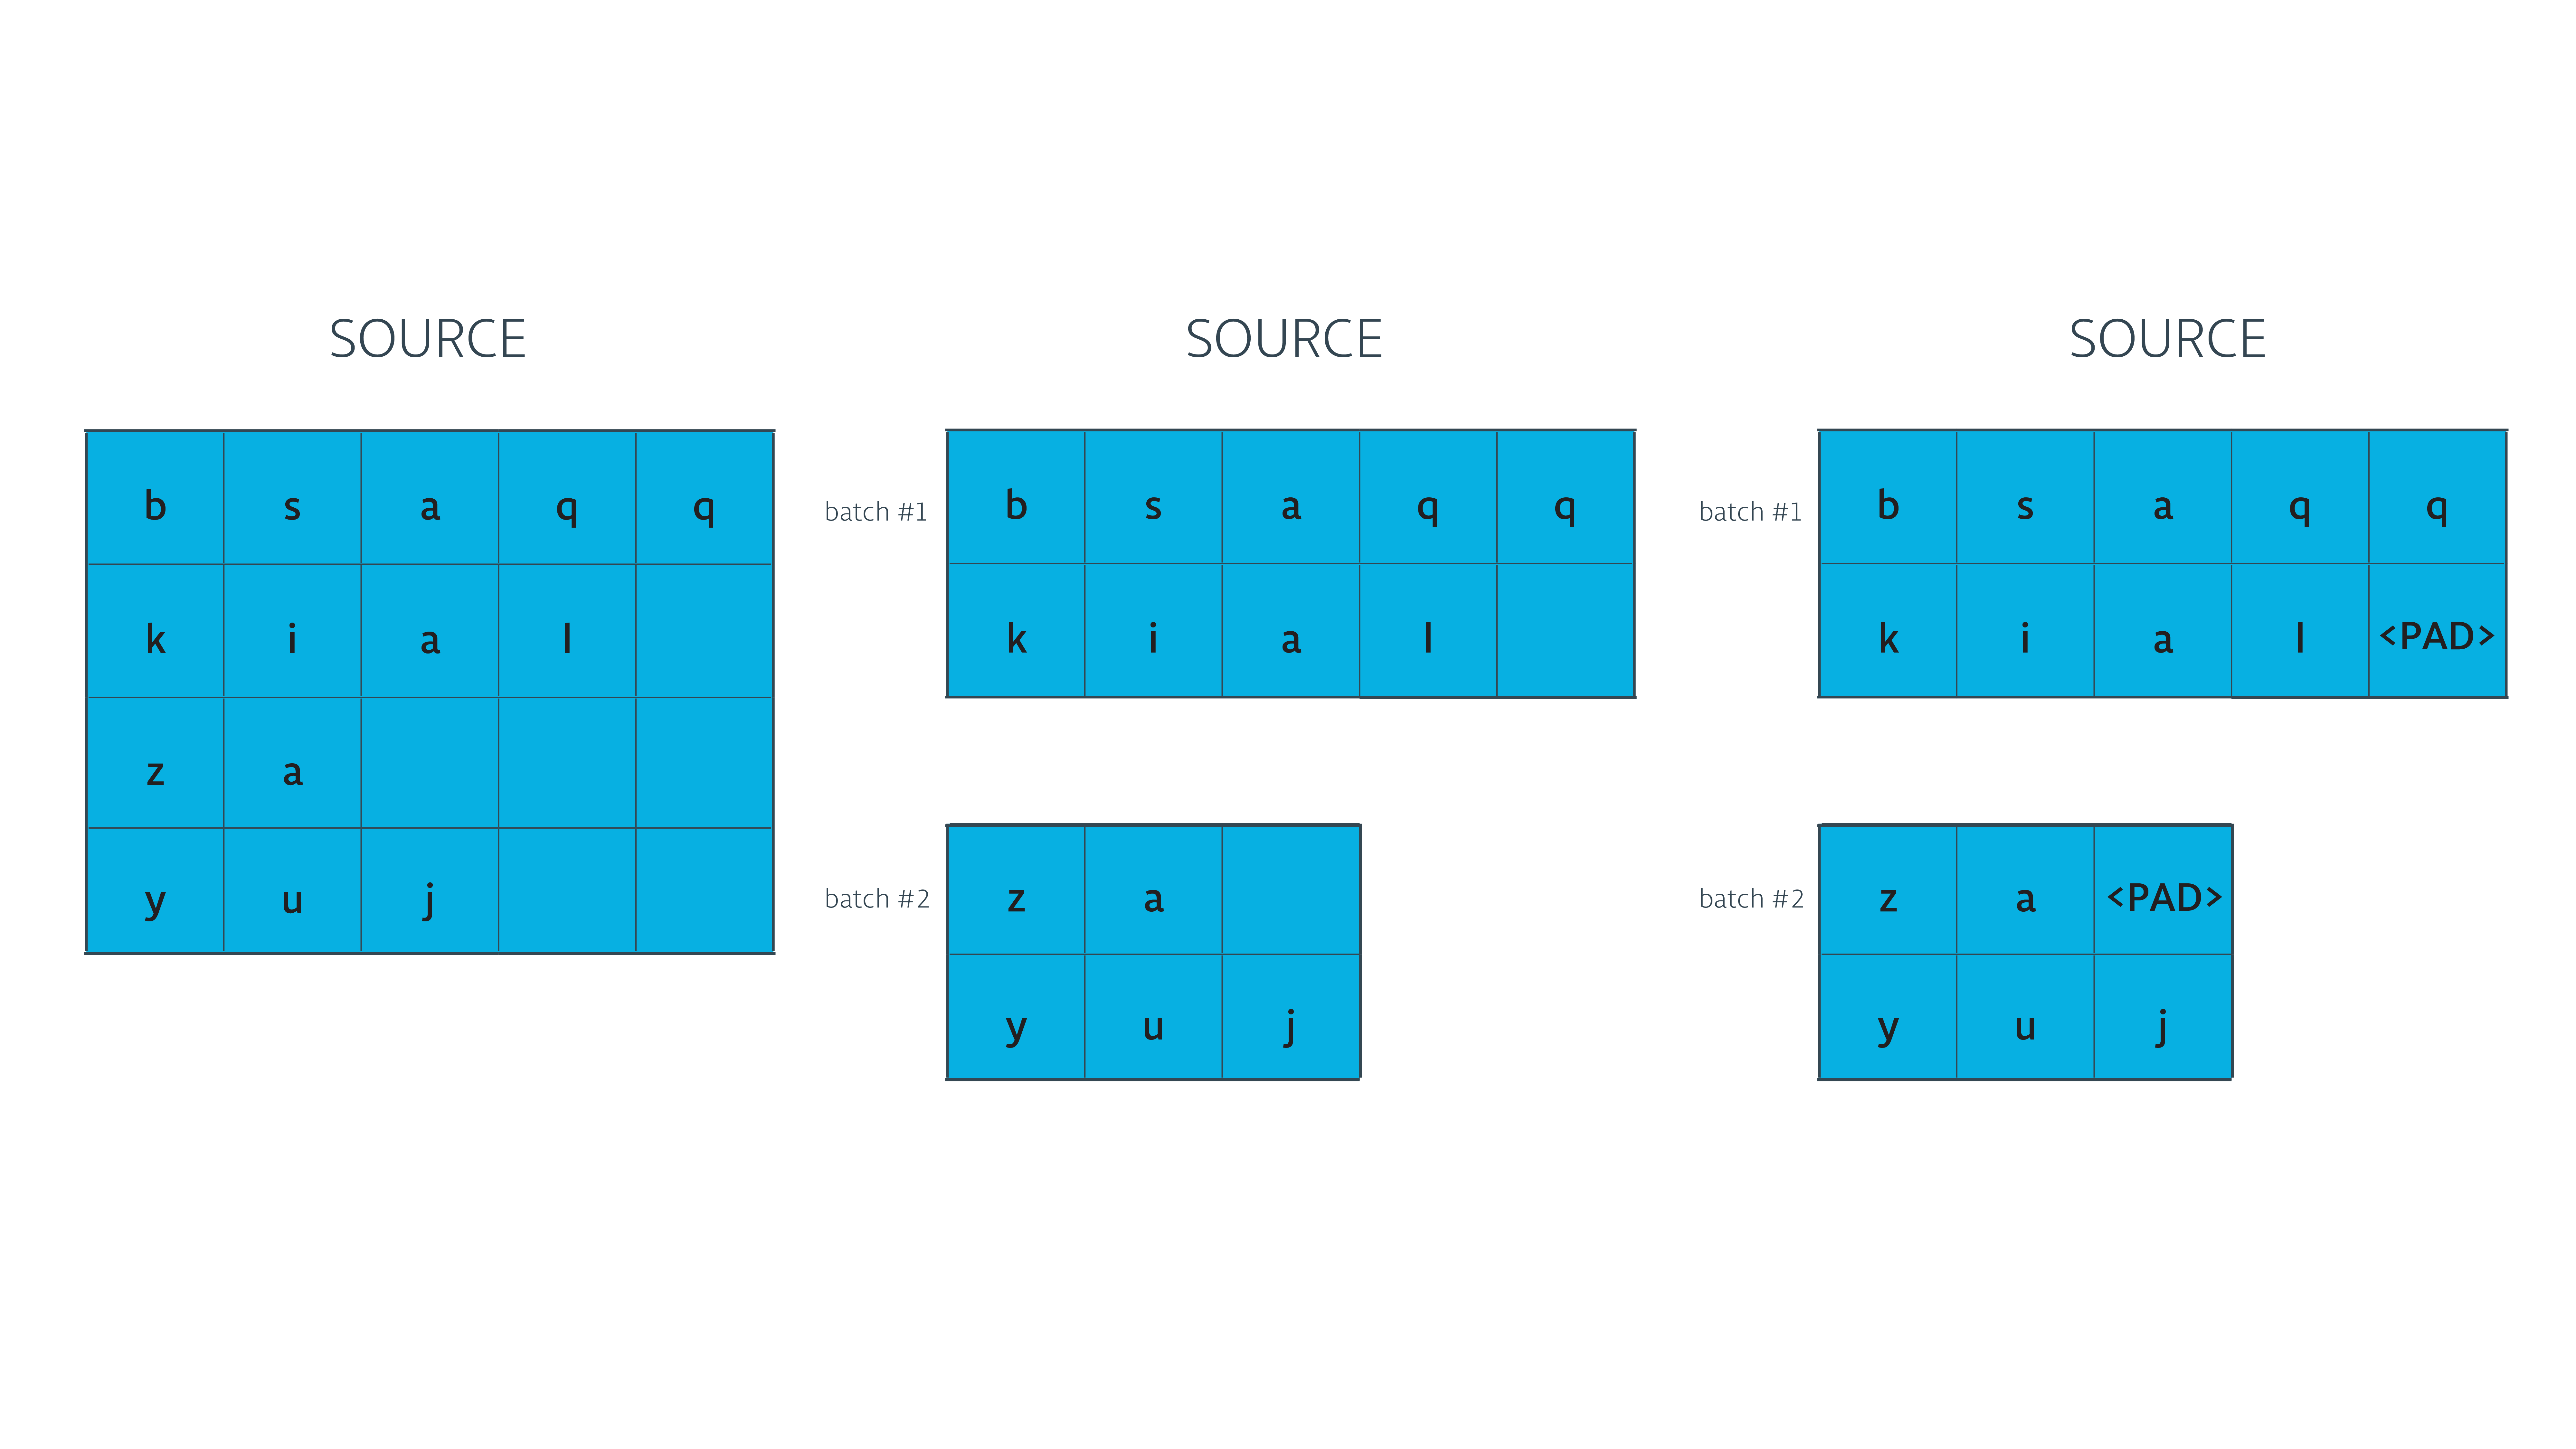

In [13]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/target_batch.png')

　　目标序列:

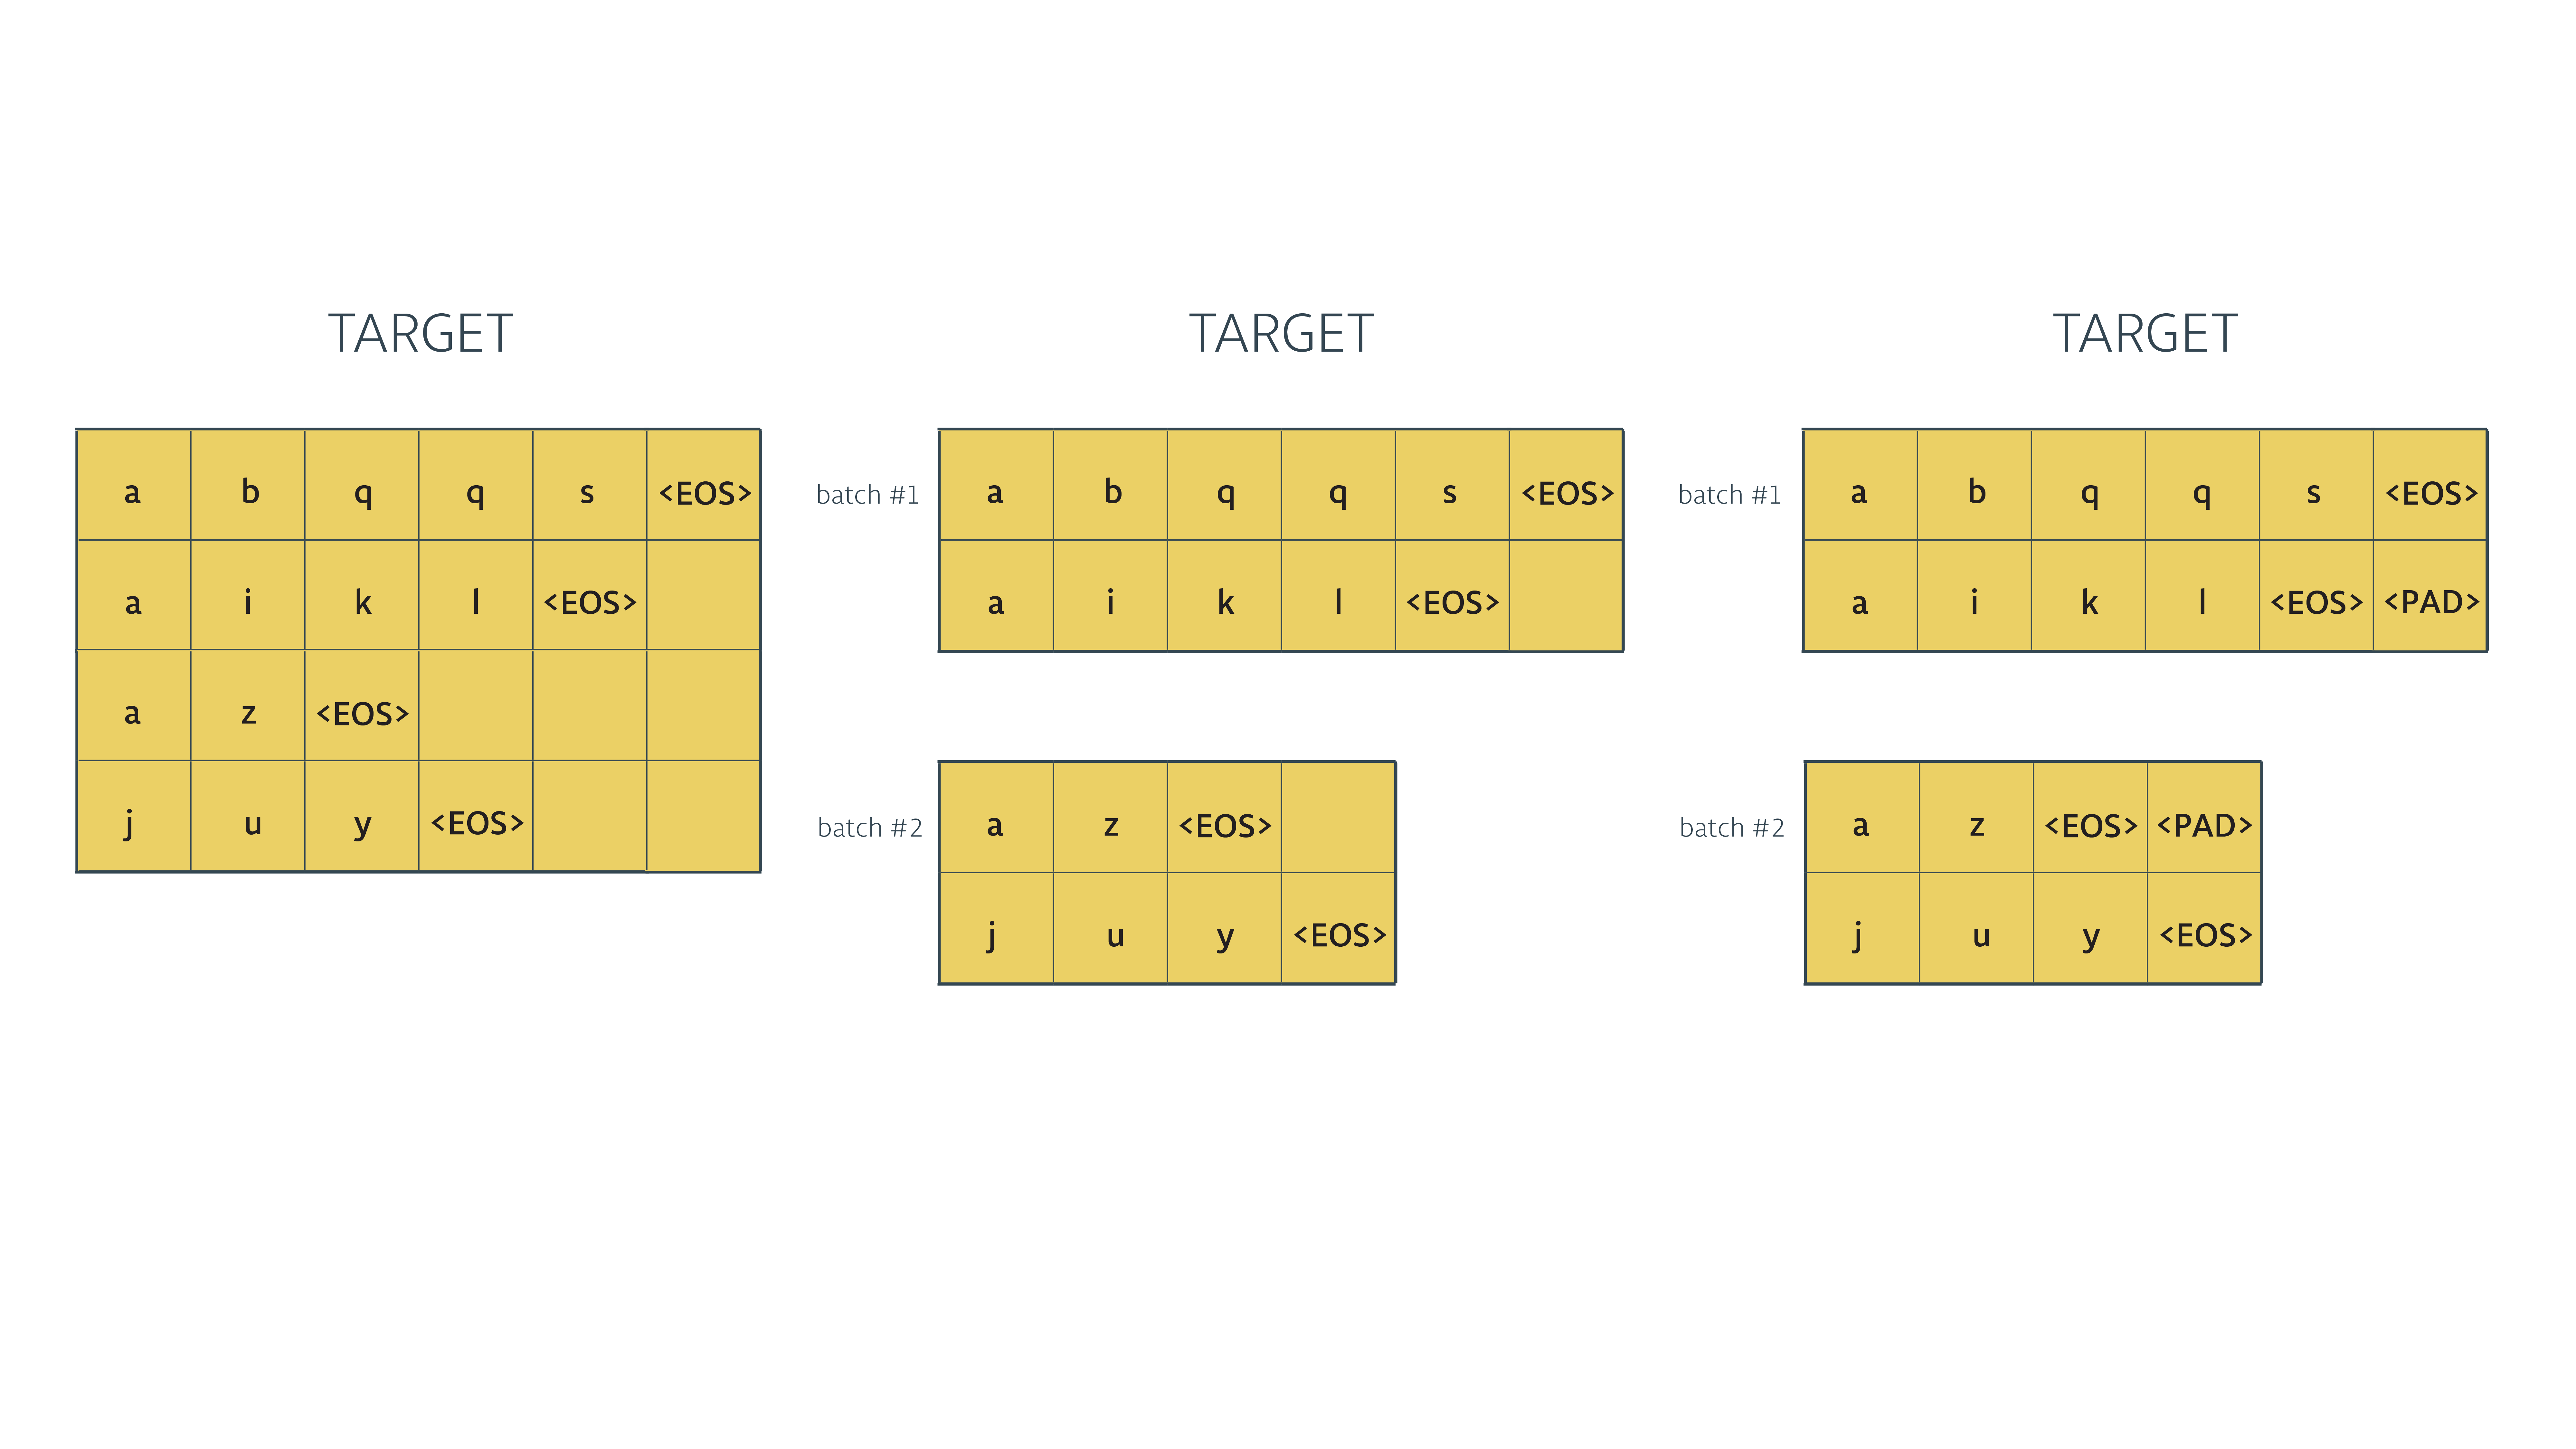

In [12]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/seq2seq/images/source_batch.png')

In [47]:
# 对 batch 中的每个序列使用 <PAD> 进行填充，保证每个序列的长度一致
def pad_sentence_batch(sentence_batch, pad_int):
    '''
    Args:
        sentence_batch: batch, 包含序列
        pad_int: <PAD>对应的索引号，用于填充
    '''
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]

In [51]:
# 获取 batch 数据
def get_batches(targets, sources, batch_size, source_pad_int, target_pad_int):
    for batch_i in range(0, len(sources) // batch_size):
        start_i = batch_i * batch_size
        # 使用索引切分数据集sources
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]
        # batch中的每个序列填充到相同长度
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))
        
        # 填充后，记录每个序列的长度
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))

        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))
            
        yield pad_targets_batch, pad_sources_batch, pad_targets_lengths, pad_source_lengths

## 训练模型
　　如果在训练期间遇到 OOM（内存不够） 的问题，尝试降低 batch_size

In [56]:
# 切分数据为训练集和验证集
train_source = source_letter_ids[batch_size:]
train_target = target_letter_ids[batch_size:]
# 留出一个 batch 进行验证
valid_source = source_letter_ids[:batch_size]
valid_target = target_letter_ids[:batch_size]

(valid_targets_batch, valid_sources_batch, valid_targets_lengths, valid_sources_lengths) = next(get_batches(valid_target, valid_source, batch_size,
                           source_letter_to_int['<PAD>'],
                           target_letter_to_int['<PAD>']))

# 每 20个 batches 检查训练集的损失
display_step = 20 

checkpoint = 'best_model.ckpt'
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch_i in range(1, epochs+1):
        for batch_i, (targets_batch, sources_batch, targets_lengths, sources_lengths) in enumerate(
            get_batches(train_target, train_source, batch_size, source_letter_to_int['<PAD>'], target_letter_to_int['<PAD>'])):
            
            _, loss = sess.run([train_op, cost], feed_dict={input_data: sources_batch,
                                                                                    targets: targets_batch,
                                                                                    lr: learning_rate,
                                                                                    target_sequence_length: targets_lengths,
                                                                                    source_sequence_length: sources_lengths})
                
            if batch_i % display_step == 0 and batch_i > 0:
                # 计算验证集损失
                validation_loss = sess.run([cost], feed_dict={input_data: valid_sources_batch,
                                                                                       targets: valid_targets_batch,
                                                                                       lr: learning_rate,
                                                                                       target_sequence_length: valid_targets_lengths,
                                                                                       source_sequence_length: valid_sources_lengths})
                
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}  - Validation loss: {:>6.3f}'.format(epoch_i, epochs,  batch_i, 
                              len(train_source) // batch_size,  loss,  validation_loss[0]))

    
    
    # 保存模型
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(os.getcwd(), checkpoint))
    print('Model Trained and Saved')

Epoch   1/60 Batch   20/77 - Loss:  2.354  - Validation loss:  2.388
Epoch   1/60 Batch   40/77 - Loss:  2.274  - Validation loss:  2.231
Epoch   1/60 Batch   60/77 - Loss:  1.973  - Validation loss:  2.021
Epoch   2/60 Batch   20/77 - Loss:  1.706  - Validation loss:  1.786
Epoch   2/60 Batch   40/77 - Loss:  1.708  - Validation loss:  1.670
Epoch   2/60 Batch   60/77 - Loss:  1.526  - Validation loss:  1.567
Epoch   3/60 Batch   20/77 - Loss:  1.389  - Validation loss:  1.459
Epoch   3/60 Batch   40/77 - Loss:  1.466  - Validation loss:  1.432
Epoch   3/60 Batch   60/77 - Loss:  1.375  - Validation loss:  1.407
Epoch   4/60 Batch   20/77 - Loss:  1.291  - Validation loss:  1.363
Epoch   4/60 Batch   40/77 - Loss:  1.342  - Validation loss:  1.319
Epoch   4/60 Batch   60/77 - Loss:  1.207  - Validation loss:  1.262
Epoch   5/60 Batch   20/77 - Loss:  1.133  - Validation loss:  1.188
Epoch   5/60 Batch   40/77 - Loss:  1.182  - Validation loss:  1.159
Epoch   5/60 Batch   60/77 - Loss:

Epoch  40/60 Batch   60/77 - Loss:  0.025  - Validation loss:  0.035
Epoch  41/60 Batch   20/77 - Loss:  0.019  - Validation loss:  0.035
Epoch  41/60 Batch   40/77 - Loss:  0.029  - Validation loss:  0.039
Epoch  41/60 Batch   60/77 - Loss:  0.023  - Validation loss:  0.033
Epoch  42/60 Batch   20/77 - Loss:  0.018  - Validation loss:  0.032
Epoch  42/60 Batch   40/77 - Loss:  0.029  - Validation loss:  0.036
Epoch  42/60 Batch   60/77 - Loss:  0.039  - Validation loss:  0.079
Epoch  43/60 Batch   20/77 - Loss:  0.021  - Validation loss:  0.037
Epoch  43/60 Batch   40/77 - Loss:  0.026  - Validation loss:  0.035
Epoch  43/60 Batch   60/77 - Loss:  0.022  - Validation loss:  0.029
Epoch  44/60 Batch   20/77 - Loss:  0.015  - Validation loss:  0.031
Epoch  44/60 Batch   40/77 - Loss:  0.022  - Validation loss:  0.028
Epoch  44/60 Batch   60/77 - Loss:  0.019  - Validation loss:  0.028
Epoch  45/60 Batch   20/77 - Loss:  0.014  - Validation loss:  0.029
Epoch  45/60 Batch   40/77 - Loss:

## 预测

In [58]:
# 对输入数据进行转换
def source_to_seq(text):
    sequence_length = 7
    return [source_letter_to_int.get(word, source_letter_to_int['<UNK>']) for word in text] +[source_letter_to_int['<PAD>']]*(sequence_length-len(text))

In [59]:
# 输入一个单词
input_sentence = 'hello'
text = source_to_seq(input_sentence)

checkpoint = './best_model.ckpt'

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # 加载模型
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    source_sequence_length = loaded_graph.get_tensor_by_name('source_sequence_length:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    
    #Multiply by batch_size to match the model's input parameters
    answer_logits = sess.run(logits, {input_data: [text]*batch_size, 
                                      target_sequence_length: [len(text)]*batch_size, 
                                      source_sequence_length: [len(text)]*batch_size})[0] 


pad = source_letter_to_int["<PAD>"] 

print('Original Text:', input_sentence)

print('\nSource')
print('  Word Ids:    {}'.format([i for i in text]))
print('  Input Words: {}'.format(" ".join([source_int_to_letter[i] for i in text])))

print('\nTarget')
print('  Word Ids:       {}'.format([i for i in answer_logits if i != pad]))
print('  Response Words: {}'.format(" ".join([target_int_to_letter[i] for i in answer_logits if i != pad])))

INFO:tensorflow:Restoring parameters from ./best_model.ckpt
Original Text: hello

Source
  Word Ids:    [21, 11, 4, 4, 18, 0, 0]
  Input Words: h e l l o <PAD> <PAD>

Target
  Word Ids:       [11, 21, 4, 4, 18, 3]
  Response Words: e h l l o <EOS>
